https://zzcojoa.tistory.com/91

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.1 MB 5.9 MB/s 


In [2]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.2 MB 4.9 MB/s 


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [5]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list ÌòïÌÉúÏùò itemÏùÄ Ï≤´Î≤àÏß∏ itemÎßå Ï∂úÎ†•
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [6]:
data_dir = '/content/drive/MyDrive/data'
model_dir = '/content/drive/MyDrive/model'

# ÌõàÎ†®Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
train_json_path = data_dir + '/train_data.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- creator: MINDs Lab.
- version: 1
- data: [60000]
  - paragraphs: [1]
    - qas: [1]
      - question: Îã§ÌÖå Í∏∞ÎØ∏ÏΩîÍ∞Ä ÏµúÏ¥àÎ°ú ÏùÄÌá¥ ÏÑ†Ïñ∏ÏùÑ ÌïúÍ≤å Ïñ∏Ï†úÏßÄ
      - answers: [1]
        - answer_start: 260
        - text: 1996ÎÖÑ 9Ïõî 24Ïùº
      - id: 9_f2_wiki_2822-1
    - context: Ïû¨Ìå¨ Ïò§ÌîàÏóêÏÑú 4Ìöå Ïö∞ÏäπÌïòÏòÄÏúºÎ©∞, ÌÜµÏÇ∞ Îã®Ïãù 200Ïäπ Ïù¥ÏÉÅÏùÑ Í±∞ÎëêÏóàÎã§. 1994ÎÖÑ ÏÉùÏï† ÏµúÏ¥àÎ°ú ÏÑ∏Í≥Ñ Îû≠ÌÇπ 10ÏúÑÍ∂åÏóê ÏßÑÏûÖÌïòÏòÄÎã§. 1992ÎÖÑÏóêÎäî WTAÎ°úÎ∂ÄÌÑ∞ 'Ïò¨Ìï¥ Í∞ÄÏû• ÎßéÏùÄ Ìñ•ÏÉÅÏùÑ Î≥¥Ïó¨Ï§Ä ÏÑ†ÏàòÏÉÅ'(Most Improved Player Of The Year)ÏùÑ ÏàòÏó¨Î∞õÏïòÏúºÎ©∞, ÏùºÎ≥∏ ÎÇ®Ïûê Ìå®ÏÖò ÌòëÌöå(Japan Men's Fashion Association)Îäî Í∑∏ÎÖÄÎ•º 'Í∞ÄÏû• Ìå®ÏÖîÎÑàÎ∏îÌïú ÏÑ†Ïàò'(Most Fashionable)Î°ú Ïπ≠ÌñàÎã§. ÏÉùÏï† Îëê Î≤àÏß∏ Ïò¨Î¶ºÌîΩ Ï∞∏Í∞Ä ÏßÅÌõÑÏù∏ 1996ÎÖÑ 9Ïõî 24Ïùº ÏµúÏ¥àÎ°ú ÏùÄÌá¥Î•º ÏÑ†Ïñ∏ÌïòÏòÄÎã§. Ïù¥ÌõÑ 12ÎÖÑÎßåÏù∏ 2008ÎÖÑ 4ÏõîÏóê ÏòàÏÉÅÏπò Î™ªÌïú Î≥µÍ∑Ä ÏÑ†Ïñ∏ÏùÑ ÌïòÍ≥† Ìà¨Ïñ¥Ïóê ÎêòÎèåÏïÑÏôîÎã§. 2008ÎÖÑ 6Ïõî 15Ïùº ÎèÑÏøÑ ÏïÑÎ¶¨ÏïÑÏºÄ Ïù∏ÌÑ∞ÎÇ¥ÏÖîÎÑê Ïó¨Ïûê Ïò§Ìî

In [7]:
# Í≤ÄÏ¶ùÎç∞Ïù¥ÌÑ∞ ÌôïÏù∏
dev_json_path = data_dir + '/test_data.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- creator: MINDs Lab.
- version: 1
- data: [8538]
  - paragraphs: [1]
    - qas: [1]
      - question: Ìå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§Îäî Ïñ¥ÎîîÏóêÏÑú Î∞©ÏÜ°ÌñàÏñ¥
      - answers: [1]
        - answer_start: 167
        - text: SBS
      - id: 8_C60_wiki_1818-1
    - context: 2010ÎÖÑ 2Ïõî 14Ïùº Ìå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§Í∞Ä Ï¢ÖÏòÅÎêòÍ≥†, Ìå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§ 2Í∞Ä 2Ïõî 21Ïùº Î∞©ÏòÅÎêòÏóàÎã§. „ÄäÌå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§„ÄãÎäî 2008ÎÖÑ 3ÏõîÎ∂ÄÌÑ∞ Ï†úÏûëÏùÑ ÏãúÏûëÌïòÏòÄÏúºÎ©∞, 2008ÎÖÑ 6Ïõî 15Ïùº Ï≤´Î∞©ÏÜ° ÎêòÏóàÎã§. Ï§ÄÎßêÎ°ú ‚ÄòÌå®Îñ¥‚ÄôÏúºÎ°ú Î∂àÎ¶¨Í∏∞ÎèÑ ÌïúÎã§. 2008ÎÖÑ 8Ïõî 31Ïùº, Ï≤òÏùåÏúºÎ°ú ÏãúÏ≤≠Î•† 20%Î•º ÎèåÌååÌïòÏòÄÏúºÎ©∞ Ïù¥ÌõÑ SBSÏùò ÎåÄÌëú ÏòàÎä• ÌîÑÎ°úÍ∑∏Îû®ÏúºÎ°ú ÏûêÎ¶¨Ïû°ÏïòÎã§. ÏãúÍ≥®Ïóê Ï∞æÏïÑÍ∞Ä Ìï†ÏïÑÎ≤ÑÏßÄ¬∑Ìï†Î®∏ÎãàÎ•º Ïó¨Ìñâ Î≥¥ÎÇ¥ÎìúÎ¶¨Í≥† ÏßëÏùÑ Î¥êÎìúÎ¶¨Î©¥ÏÑú Î≤åÏñ¥ÏßÄÎäî ÏóêÌîºÏÜåÎìúÎ•º Îã¥ÎäîÎã§. Ìï†ÏïÑÎ≤ÑÏßÄ¬∑Ìï†Î®∏ÎãàÍªòÏÑú Î∂ÄÌÉÅÌïòÏã† ÏùºÏùÑ ÌïòÎ©¥ÏÑú Í≤åÏûÑÏùÑ ÌïòÍ≥†, ÏãùÏÇ¨Î•º Í∞ôÏù¥ ÌïòÎ©¥ÏÑú Î≤åÏñ¥ÏßÄÎäî 1Î∞ï 2ÏùºÏùò Î™®ÏäµÏùÑ Î≥¥Ïó¨Ï£ºÎäî ÌîÑÎ°úÍ∑∏Îû®Ïù¥Îã§. „ÄäÌå®Î∞ÄÎ¶¨Í∞Ä Î

- ÏõêÎ≥∏

In [8]:
print(json.dumps(train_json["data"][0:10], indent=2, ensure_ascii=False))

[
  {
    "paragraphs": [
      {
        "qas": [
          {
            "question": "Îã§ÌÖå Í∏∞ÎØ∏ÏΩîÍ∞Ä ÏµúÏ¥àÎ°ú ÏùÄÌá¥ ÏÑ†Ïñ∏ÏùÑ ÌïúÍ≤å Ïñ∏Ï†úÏßÄ",
            "answers": [
              {
                "answer_start": 260,
                "text": "1996ÎÖÑ 9Ïõî 24Ïùº"
              }
            ],
            "id": "9_f2_wiki_2822-1"
          }
        ],
        "context": "Ïû¨Ìå¨ Ïò§ÌîàÏóêÏÑú 4Ìöå Ïö∞ÏäπÌïòÏòÄÏúºÎ©∞, ÌÜµÏÇ∞ Îã®Ïãù 200Ïäπ Ïù¥ÏÉÅÏùÑ Í±∞ÎëêÏóàÎã§. 1994ÎÖÑ ÏÉùÏï† ÏµúÏ¥àÎ°ú ÏÑ∏Í≥Ñ Îû≠ÌÇπ 10ÏúÑÍ∂åÏóê ÏßÑÏûÖÌïòÏòÄÎã§. 1992ÎÖÑÏóêÎäî WTAÎ°úÎ∂ÄÌÑ∞ 'Ïò¨Ìï¥ Í∞ÄÏû• ÎßéÏùÄ Ìñ•ÏÉÅÏùÑ Î≥¥Ïó¨Ï§Ä ÏÑ†ÏàòÏÉÅ'(Most Improved Player Of The Year)ÏùÑ ÏàòÏó¨Î∞õÏïòÏúºÎ©∞, ÏùºÎ≥∏ ÎÇ®Ïûê Ìå®ÏÖò ÌòëÌöå(Japan Men's Fashion Association)Îäî Í∑∏ÎÖÄÎ•º 'Í∞ÄÏû• Ìå®ÏÖîÎÑàÎ∏îÌïú ÏÑ†Ïàò'(Most Fashionable)Î°ú Ïπ≠ÌñàÎã§. ÏÉùÏï† Îëê Î≤àÏß∏ Ïò¨Î¶ºÌîΩ Ï∞∏Í∞Ä ÏßÅÌõÑÏù∏ 1996ÎÖÑ 9Ïõî 24Ïùº ÏµúÏ¥àÎ°ú ÏùÄÌá¥Î•º ÏÑ†Ïñ∏ÌïòÏòÄÎã§. Ïù¥ÌõÑ 12ÎÖÑÎßåÏù∏ 2008ÎÖÑ 4ÏõîÏóê ÏòàÏÉÅÏπò Î™ªÌïú Î≥µÍ∑Ä ÏÑ†Ïñ∏ÏùÑ ÌïòÍ≥† Ìà

In [9]:
print(json.dumps(dev_json["data"][130:140], indent=2, ensure_ascii=False))

[
  {
    "paragraphs": [
      {
        "qas": [
          {
            "question": "Îü¨ÏãúÏïÑÏùò ÏßëÏù¥ÎÇò ÏãùÎãπÏóêÏÑú Í∞ÄÏû• ÌùîÌûà Ï†úÍ≥µÌïòÎäî ÏàòÌîÑÎäî",
            "answers": [
              {
                "answer_start": 136,
                "text": "Î≥¥Î•¥Ïãú"
              }
            ],
            "id": "9_f7_wiki_1700-1"
          }
        ],
        "context": "Í∏∞Î¶ÑÍ∏∞Î•º ÎùÑÎ©∞ Ïã†ÎßõÏù¥ Í∞ïÌïòÎã§. ÏòÅÏñ¥Ïãù ÌëúÍ∏∞Ïù∏ 'borshch'Î•º Í∑∏ÎåÄÎ°ú ÏòÆÍ≤® Ï†ÅÏñ¥ 'Î≥¥Î•¥ÏãúÏπò'ÎùºÍ≥† ÏûòÎ™ª ÌëúÍ∏∞ÎêòÎäî Í≤ΩÏö∞Í∞Ä ÎßéÎã§. ÏõêÎûòÎäî Ïö∞ÌÅ¨ÎùºÏù¥ÎÇòÍ∞Ä ÏõêÏ°∞ÎùºÍ≥† ÏÉùÍ∞ÅÎêòÏßÄÎßå ÎèôÏú†ÎüΩÍ≥º Ï§ëÏïôÏú†ÎüΩ Ïó¨Îü¨ ÎÇòÎùºÏóêÏÑú ÎÑêÎ¶¨ ÏÑ†Ìò∏ÌïòÎäî ÏöîÎ¶¨Ïù¥Îã§. ÌäπÌûà Îü¨ÏãúÏïÑÏùò Í≤ΩÏö∞ Î≥¥Î•¥ÏãúÎäî ÎåÄÌëúÏ†Å Ï†ÑÌÜµ ÏùåÏãùÏúºÎ°ú Ïó¨Í≤®ÏßÑÎã§. Îü¨ÏãúÏïÑ Íµ≠ÎØºÎì§ÏùÄ ÏÇ¨Í≥ÑÏ†à ÎÇ¥ÎÇ¥ Ïù¥Î•º Ï¶êÍ≤® Î®πÍ≥§ ÌïòÎ©∞, ÏßëÏù¥ÎÇò ÏãùÎãπÏóêÏÑú Í∞ÄÏû• ÌùîÌûà Ï†úÍ≥µÌïòÎäî ÏàòÌîÑÏù¥Îã§. ÏÇ¨ÌÉïÎ¨¥, ÏñëÌåå, ÎãπÍ∑º, Ïá†Í≥†Í∏∞ Îì±Ïùò Ïû¨Î£åÎ•º Î≥∂Í≥† ÎÇòÏÑú ÏàòÌîÑÎ°ú Ï≤úÏ≤úÌûà ÏÇ∂ÏïÑÏÑú Îß

## KorQuAD Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (1) ÎùÑÏñ¥Ïì∞Í∏∞ Îã®ÏúÑ Ï†ïÎ≥¥Í¥ÄÎ¶¨

In [10]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [11]:
# whitespaceÍ∞Ä 2Í∞úÏù∏ Í≤ΩÏö∞Î•º Ï≤òÎ¶¨Ìï¥Ïïº Ìï®

string1 = '1839ÎÖÑ ÌååÏö∞Ïä§Ìä∏Î•º ÏùΩÏóàÎã§.'
string2 = '1839ÎÖÑ  ÌååÏö∞Ïä§Ìä∏Î•º ÏùΩÏóàÎã§.'
string1[6:10], string2[7:11]

('ÌååÏö∞Ïä§Ìä∏', 'ÌååÏö∞Ïä§Ìä∏')

In [12]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# Ï≤´Î≤àÏß∏ Î¨∏Ïû•(string1)Ïóê ÎåÄÌï¥ ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º ÌëúÏãú
for c in string1:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'ÎÖÑ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0]
' ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0, 0]
'Ìåå' : ['1839ÎÖÑ', 'Ìåå'] : [0, 0, 0, 0, 0, 0, 1]
'Ïö∞' : ['1839ÎÖÑ', 'ÌååÏö∞'] : [0, 0, 0, 0, 0, 0, 1, 1]
'Ïä§' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§'] : [0, 0, 0, 0, 0, 0, 1, 1, 1]
'Ìä∏' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'Î•º' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'ÏùΩ' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩ'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'Ïóà' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóà'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'Îã§' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


In [13]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# ÎëêÎ≤àÏß∏ Î¨∏Ïû•(string2)Ïóê ÎåÄÌï¥ ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º ÌëúÏãú
for c in string2:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'ÎÖÑ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0]
' ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0, 0]
' ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0, 0, 0]
'Ìåå' : ['1839ÎÖÑ', 'Ìåå'] : [0, 0, 0, 0, 0, 0, 0, 1]
'Ïö∞' : ['1839ÎÖÑ', 'ÌååÏö∞'] : [0, 0, 0, 0, 0, 0, 0, 1, 1]
'Ïä§' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
'Ìä∏' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'Î•º' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'ÏùΩ' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩ'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'Ïóà' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóà'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'Îã§' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1

In [14]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

In [15]:
# Ï≤´Î≤àÏß∏ Î¨∏Ïû•(string1)Ïóê ÎåÄÌï¥ ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º ÌëúÏãú
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'ÎÖÑ' : 0
' ' : 0
'Ìåå' : 1
'Ïö∞' : 1
'Ïä§' : 1
'Ìä∏' : 1
'Î•º' : 1
' ' : 1
'ÏùΩ' : 2
'Ïóà' : 2
'Îã§' : 2
'.' : 2


(['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [16]:
# ÎëêÎ≤àÏß∏ Î¨∏Ïû•(string2)Ïóê ÎåÄÌï¥ ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º ÌëúÏãú
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'ÎÖÑ' : 0
' ' : 0
' ' : 0
'Ìåå' : 1
'Ïö∞' : 1
'Ïä§' : 1
'Ìä∏' : 1
'Î•º' : 1
' ' : 1
'ÏùΩ' : 2
'Ïóà' : 2
'Îã§' : 2
'.' : 2


(['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.'],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

## Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (2) Tokenize by Vocab

In [17]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

# wordÎ•º subwordÎ°ú Î≥ÄÍ≤ΩÌïòÎ©¥ÏÑú index Ï†ÄÏû•
word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens):
    word_to_token.append(len(context_tokens))
    tokens = vocab.encode_as_pieces(word)  # SentencePieceÎ•º ÏÇ¨Ïö©Ìï¥ SubwordÎ°ú Ï™ºÍ∞≠ÎãàÎã§.
    for token in tokens:
        context_tokens.append(token)

context_tokens, word_to_token

(['‚ñÅ1839', 'ÎÖÑ', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'Î•º', '‚ñÅÏùΩ', 'ÏóàÎã§', '.'], [0, 2, 5])

In [18]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [19]:
print(word_tokens)  # Ï≤òÎ¶¨Ìï¥Ïïº Ìï† word Îã®ÏúÑ ÏûÖÎ†•

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token   # Subword Îã®ÏúÑÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥º

['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.']


(['‚ñÅ1839', 'ÎÖÑ', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'Î•º', '‚ñÅÏùΩ', 'ÏóàÎã§', '.'], [0, 2, 5])

###KorQuAD Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (3) Improve Span

In [20]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_textÏóê Ìï¥ÎãπÌïòÎäî context ÏòÅÏó≠ÏùÑ Ï†ïÌôïÌûà Ï∞æÏïÑÎÇ¥Ïïº Ìï©ÎãàÎã§. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  Ïû¨Ìå¨ Ïò§ÌîàÏóêÏÑú 4Ìöå Ïö∞ÏäπÌïòÏòÄÏúºÎ©∞, ÌÜµÏÇ∞ Îã®Ïãù 200Ïäπ Ïù¥ÏÉÅÏùÑ Í±∞ÎëêÏóàÎã§. 1994ÎÖÑ ÏÉùÏï† ÏµúÏ¥àÎ°ú ÏÑ∏Í≥Ñ Îû≠ÌÇπ 10ÏúÑÍ∂åÏóê ÏßÑÏûÖÌïòÏòÄÎã§. 1992ÎÖÑÏóêÎäî WTAÎ°úÎ∂ÄÌÑ∞ 'Ïò¨Ìï¥ Í∞ÄÏû• ÎßéÏùÄ Ìñ•ÏÉÅÏùÑ Î≥¥Ïó¨Ï§Ä ÏÑ†ÏàòÏÉÅ'(Most Improved Player Of The Year)ÏùÑ ÏàòÏó¨Î∞õÏïòÏúºÎ©∞, ÏùºÎ≥∏ ÎÇ®Ïûê Ìå®ÏÖò ÌòëÌöå(Japan Men's Fashion Association)Îäî Í∑∏ÎÖÄÎ•º 'Í∞ÄÏû• Ìå®ÏÖîÎÑàÎ∏îÌïú ÏÑ†Ïàò'(Most Fashionable)Î°ú Ïπ≠ÌñàÎã§. ÏÉùÏï† Îëê Î≤àÏß∏ Ïò¨Î¶ºÌîΩ Ï∞∏Í∞Ä ÏßÅÌõÑÏù∏ 1996ÎÖÑ 9Ïõî 24Ïùº ÏµúÏ¥àÎ°ú ÏùÄÌá¥Î•º ÏÑ†Ïñ∏ÌïòÏòÄÎã§. Ïù¥ÌõÑ 12ÎÖÑÎßåÏù∏ 2008ÎÖÑ 4ÏõîÏóê ÏòàÏÉÅÏπò Î™ªÌïú Î≥µÍ∑Ä ÏÑ†Ïñ∏ÏùÑ ÌïòÍ≥† Ìà¨Ïñ¥Ïóê ÎêòÎèåÏïÑÏôîÎã§. 2008ÎÖÑ 6Ïõî 15Ïùº ÎèÑÏøÑ ÏïÑÎ¶¨ÏïÑÏºÄ Ïù∏ÌÑ∞ÎÇ¥ÏÖîÎÑê Ïó¨Ïûê Ïò§ÌîàÏóêÏÑú Î≥µÍ∑Ä ÌõÑ Ï≤´ Ïö∞ÏäπÏùÑ Í∏∞Î°ùÌñàÏúºÎ©∞, 2009ÎÖÑ 9Ïõî 27ÏùºÏóêÎäî ÌïúÍµ≠ÏóêÏÑú Ïó¥Î¶∞ ÌïúÏÜî ÏΩîÎ¶¨ÏïÑ Ïò§Ìîà ÎåÄÌöåÏóêÏÑú Ïö∞ÏäπÌïòÎ©¥ÏÑú Î≥µÍ∑Ä ÌõÑ Ï≤´ WTA Ìà¨Ïñ¥Í∏â ÎåÄÌöå Ïö∞ÏäπÏùÑ Í∏∞Î°ùÌñàÎã§. ÌïúÏà® Ï¢Ä ÏûëÏûë Ïâ¨Ïñ¥!
[question]  Îã§ÌÖå Í∏∞ÎØ∏ÏΩîÍ∞Ä ÏµúÏ¥àÎ°ú ÏùÄÌá¥ ÏÑ

In [21]:
# contextÎ•º ÎùÑÏñ¥Ïì∞Í∏∞(word) Îã®ÏúÑÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥ºÎ•º ÏÇ¥Ìé¥Î¥ÖÎãàÎã§. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['Ïû¨Ìå¨', 'Ïò§ÌîàÏóêÏÑú', '4Ìöå', 'Ïö∞ÏäπÌïòÏòÄÏúºÎ©∞,', 'ÌÜµÏÇ∞', 'Îã®Ïãù', '200Ïäπ', 'Ïù¥ÏÉÅÏùÑ', 'Í±∞ÎëêÏóàÎã§.', '1994ÎÖÑ', 'ÏÉùÏï†', 'ÏµúÏ¥àÎ°ú', 'ÏÑ∏Í≥Ñ', 'Îû≠ÌÇπ', '10ÏúÑÍ∂åÏóê', 'ÏßÑÏûÖÌïòÏòÄÎã§.', '1992ÎÖÑÏóêÎäî', 'WTAÎ°úÎ∂ÄÌÑ∞', "'Ïò¨Ìï¥", 'Í∞ÄÏû•']


([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4],
 'Ïû¨Ìå¨ Ïò§ÌîàÏóêÏÑú 4Ìöå Ïö∞ÏäπÌïòÏòÄÏúºÎ©∞, ÌÜµ')

In [22]:
# ÎùÑÏñ¥Ïì∞Í∏∞(word) Îã®ÏúÑÎ°ú Ï™ºÍ∞úÏßÑ context(word_tokens)Î•º SubwordÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥ºÎ•º ÏÇ¥Ìé¥Î¥ÖÎãàÎã§. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['‚ñÅÏû¨Ìå¨']
1 ['‚ñÅÏò§Ìîà', 'ÏóêÏÑú']
3 ['‚ñÅ4', 'Ìöå']
5 ['‚ñÅÏö∞Ïäπ', 'ÌïòÏòÄÏúºÎ©∞', ',']
8 ['‚ñÅÌÜµÏÇ∞']
9 ['‚ñÅÎã®Ïãù']
10 ['‚ñÅ200', 'Ïäπ']
12 ['‚ñÅÏù¥ÏÉÅÏùÑ']
13 ['‚ñÅÍ±∞ÎëêÏóàÎã§', '.']
15 ['‚ñÅ1994', 'ÎÖÑ']
17 ['‚ñÅÏÉùÏï†']
18 ['‚ñÅÏµúÏ¥àÎ°ú']
19 ['‚ñÅÏÑ∏Í≥Ñ']
20 ['‚ñÅÎû≠ÌÇπ']
21 ['‚ñÅ10', 'ÏúÑÍ∂å', 'Ïóê']
24 ['‚ñÅÏßÑÏûÖ', 'ÌïòÏòÄÎã§', '.']
27 ['‚ñÅ1992', 'ÎÖÑÏóêÎäî']
29 ['‚ñÅW', 'TA', 'Î°úÎ∂ÄÌÑ∞']
32 ["‚ñÅ'", 'Ïò¨', 'Ìï¥']
35 ['‚ñÅÍ∞ÄÏû•']


In [23]:
# answer_startÏôÄ answer_endÎ°úÎ∂ÄÌÑ∞ word_startÏôÄ word_endÎ•º Íµ¨Ìï©ÎãàÎã§. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(49, 51, '1996ÎÖÑ 9Ïõî 24Ïùº', ['1996ÎÖÑ', '9Ïõî', '24Ïùº'])

In [24]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(104, 109, ['‚ñÅ1996', 'ÎÖÑ', '‚ñÅ9', 'Ïõî', '‚ñÅ24', 'Ïùº'])

In [25]:
# Ïã§Ï†ú Ï†ïÎãµÏù∏ answer_textÎèÑ Subword Í∏∞Ï§ÄÏúºÎ°ú ÌÜ†ÌÅ∞ÌôîÌï¥ Îë°ÎãàÎã§. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'‚ñÅ1996 ÎÖÑ ‚ñÅ9 Ïõî ‚ñÅ24 Ïùº'

In [26]:
# Ï†ïÎãµÏù¥ Îê†Ïàò ÏûàÎäî new_startÏôÄ new_endÏùò Í≤ΩÏö∞Î•º ÏàúÌöåÌÉêÏÉâÌï©ÎãàÎã§. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # Ï†ïÎãµÍ≥º ÏùºÏπòÌïòÎäî Í≤ΩÏö∞
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

O >> (104, 109) ‚ñÅ1996 ÎÖÑ ‚ñÅ9 Ïõî ‚ñÅ24 Ïùº
X >> (104, 108) ‚ñÅ1996 ÎÖÑ ‚ñÅ9 Ïõî ‚ñÅ24
X >> (104, 107) ‚ñÅ1996 ÎÖÑ ‚ñÅ9 Ïõî
X >> (104, 106) ‚ñÅ1996 ÎÖÑ ‚ñÅ9
X >> (104, 105) ‚ñÅ1996 ÎÖÑ
X >> (104, 104) ‚ñÅ1996
X >> (105, 109) ÎÖÑ ‚ñÅ9 Ïõî ‚ñÅ24 Ïùº
X >> (105, 108) ÎÖÑ ‚ñÅ9 Ïõî ‚ñÅ24
X >> (105, 107) ÎÖÑ ‚ñÅ9 Ïõî
X >> (105, 106) ÎÖÑ ‚ñÅ9
X >> (105, 105) ÎÖÑ
X >> (106, 109) ‚ñÅ9 Ïõî ‚ñÅ24 Ïùº
X >> (106, 108) ‚ñÅ9 Ïõî ‚ñÅ24
X >> (106, 107) ‚ñÅ9 Ïõî
X >> (106, 106) ‚ñÅ9
X >> (107, 109) Ïõî ‚ñÅ24 Ïùº
X >> (107, 108) Ïõî ‚ñÅ24
X >> (107, 107) Ïõî
X >> (108, 109) ‚ñÅ24 Ïùº
X >> (108, 108) ‚ñÅ24
X >> (109, 109) Ïùº


In [27]:
# context_tokensÏóêÏÑú char_answerÏùò ÏúÑÏπòÎ•º Ï∞æÏïÑ Î¶¨ÌÑ¥ÌïòÎäî Ìï®Ïàò
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [28]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 104  token_end: 109


['‚ñÅ1996', 'ÎÖÑ', '‚ñÅ9', 'Ïõî', '‚ñÅ24', 'Ïùº']

## Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (4) Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÎ¶¨

In [29]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    if char_answer not in word_answer:
                      break                  

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    #print(data)
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [ ]:
# Ï†ÑÏ≤òÎ¶¨Î•º ÏàòÌñâÌïòÏó¨ ÌååÏùºÎ°ú ÏÉùÏÑ±Ìï©ÎãàÎã§. 
dump_korquad(vocab, train_json, "/content/drive/MyDrive/AI_hub/TRAIN.json")
dump_korquad(vocab, dev_json, "/content/drive/MyDrive/AI_hub/TEST.json")

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/8538 [00:00<?, ?it/s]

In [32]:
def print_file(filename, count=10):
    """
    ÌååÏùº ÎÇ¥Ïö© Ï∂úÎ†•
    :param filename: ÌååÏùº Ïù¥Î¶Ñ
    :param count: Ï∂úÎ†• ÎùºÏù∏ Ïàò
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(data_dir + '/TRAIN_preprocessing.json') #####

{"qa_id": "9_f2_wiki_2822-1", "title": "Îã§ÌÖå_Í∏∞ÎØ∏ÏΩî", "question": ["‚ñÅÎã§ÌÖå", "‚ñÅÍ∏∞ÎØ∏", "ÏΩîÍ∞Ä", "‚ñÅÏµúÏ¥àÎ°ú", "‚ñÅÏùÄÌá¥", "‚ñÅÏÑ†Ïñ∏ÏùÑ", "‚ñÅÌïú", "Í≤å", "‚ñÅÏñ∏Ï†ú", "ÏßÄ"], "context": ["‚ñÅÏû¨Ìå¨", "‚ñÅÏò§Ìîà", "ÏóêÏÑú", "‚ñÅ4", "Ìöå", "‚ñÅÏö∞Ïäπ", "ÌïòÏòÄÏúºÎ©∞", ",", "‚ñÅÌÜµÏÇ∞", "‚ñÅÎã®Ïãù", "‚ñÅ200", "Ïäπ", "‚ñÅÏù¥ÏÉÅÏùÑ", "‚ñÅÍ±∞ÎëêÏóàÎã§", ".", "‚ñÅ1994", "ÎÖÑ", "‚ñÅÏÉùÏï†", "‚ñÅÏµúÏ¥àÎ°ú", "‚ñÅÏÑ∏Í≥Ñ", "‚ñÅÎû≠ÌÇπ", "‚ñÅ10", "ÏúÑÍ∂å", "Ïóê", "‚ñÅÏßÑÏûÖ", "ÌïòÏòÄÎã§", ".", "‚ñÅ1992", "ÎÖÑÏóêÎäî", "‚ñÅW", "TA", "Î°úÎ∂ÄÌÑ∞", "‚ñÅ'", "Ïò¨", "Ìï¥", "‚ñÅÍ∞ÄÏû•", "‚ñÅÎßéÏùÄ", "‚ñÅÌñ•ÏÉÅÏùÑ", "‚ñÅÎ≥¥Ïó¨Ï§Ä", "‚ñÅÏÑ†Ïàò", "ÏÉÅ", "'(", "M", "ost", "‚ñÅ", "Imp", "ro", "v", "ed", "‚ñÅP", "layer", "‚ñÅOf", "‚ñÅThe", "‚ñÅYear", ")", "ÏùÑ", "‚ñÅÏàòÏó¨", "Î∞õÏïòÏúºÎ©∞", ",", "‚ñÅÏùºÎ≥∏", "‚ñÅÎÇ®Ïûê", "‚ñÅÌå®ÏÖò", "‚ñÅÌòëÌöå", "(", "Ja", "pan", "‚ñÅM", "en", "'", "s", "‚ñÅF", "ash", "ion", "‚ñÅAssociation", ")", "Îäî", "‚ñÅÍ∑∏ÎÖÄÎ•º", "‚ñÅ'", "Í∞Ä", "Ïû•", "‚ñÅÌå®", "ÏÖî", "ÎÑà"

In [33]:
print_file(data_dir + '/TEST_preprocessing.json') #####

{"qa_id": "8_C60_wiki_1818-1", "title": "Ìå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§", "question": ["‚ñÅÌå®Î∞ÄÎ¶¨", "Í∞Ä", "‚ñÅ", "Îñ¥", "Îã§", "Îäî", "‚ñÅÏñ¥Îîî", "ÏóêÏÑú", "‚ñÅÎ∞©ÏÜ°", "ÌñàÏñ¥"], "context": ["‚ñÅ2010", "ÎÖÑ", "‚ñÅ2", "Ïõî", "‚ñÅ14", "Ïùº", "‚ñÅÌå®Î∞ÄÎ¶¨", "Í∞Ä", "‚ñÅ", "Îñ¥", "Îã§Í∞Ä", "‚ñÅÏ¢ÖÏòÅ", "ÎêòÍ≥†", ",", "‚ñÅÌå®Î∞ÄÎ¶¨", "Í∞Ä", "‚ñÅ", "Îñ¥", "Îã§", "‚ñÅ2", "Í∞Ä", "‚ñÅ2", "Ïõî", "‚ñÅ21", "Ïùº", "‚ñÅÎ∞©ÏòÅÎêòÏóàÎã§", ".", "‚ñÅ„Ää", "Ìå®", "Î∞ÄÎ¶¨", "Í∞Ä", "‚ñÅ", "Îñ¥", "Îã§", "„Äã", "Îäî", "‚ñÅ2008", "ÎÖÑ", "‚ñÅ3", "ÏõîÎ∂ÄÌÑ∞", "‚ñÅÏ†úÏûëÏùÑ", "‚ñÅÏãúÏûëÌïòÏòÄÏúºÎ©∞", ",", "‚ñÅ2008", "ÎÖÑ", "‚ñÅ6", "Ïõî", "‚ñÅ15", "Ïùº", "‚ñÅÏ≤´", "Î∞©ÏÜ°", "‚ñÅÎêòÏóàÎã§", ".", "‚ñÅÏ§Ä", "Îßê", "Î°ú", "‚ñÅ‚Äò", "Ìå®", "Îñ¥", "‚Äô", "ÏúºÎ°ú", "‚ñÅÎ∂àÎ¶¨Í∏∞ÎèÑ", "‚ñÅÌïúÎã§", ".", "‚ñÅ2008", "ÎÖÑ", "‚ñÅ8", "Ïõî", "‚ñÅ31", "Ïùº", ",", "‚ñÅÏ≤òÏùåÏúºÎ°ú", "‚ñÅÏãúÏ≤≠Î•†", "‚ñÅ20%", "Î•º", "‚ñÅÎèåÌåå", "ÌïòÏòÄÏúºÎ©∞", "‚ñÅÏù¥ÌõÑ", "‚ñÅSBS", "Ïùò", "‚ñÅÎåÄÌëú", "‚ñÅÏòàÎä•", "‚ñÅÌîÑÎ°úÍ∑∏Îû®ÏúºÎ°ú", "‚ñÅÏûêÎ¶¨Ï

## KorQuAD Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (5) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Question

In [34]:
questions = []
contexts = []
token_starts = []
with open(data_dir + '/TRAIN_preprocessing.json') as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

104 ['‚ñÅÎã§ÌÖå', '‚ñÅÍ∏∞ÎØ∏', 'ÏΩîÍ∞Ä', '‚ñÅÏµúÏ¥àÎ°ú', '‚ñÅÏùÄÌá¥', '‚ñÅÏÑ†Ïñ∏ÏùÑ', '‚ñÅÌïú', 'Í≤å', '‚ñÅÏñ∏Ï†ú', 'ÏßÄ']
18 ['‚ñÅ', 'ave', ';', 'new', '‚ñÅÎ≥∏Í±∞ÏßÄ', '‚ñÅÏñ¥Îîî', 'Ïïº']
94 ['‚ñÅÏÇ¨Ïπ¥Ïù¥', '‚ñÅÎã§Îã§ÏöîÏãú', 'Ïùò', '‚ñÅÏïÑÎ≤ÑÏßÄÍ∞Ä', '‚ñÅÎàÑÍµ¨', 'ÏßÄ']
36 ['‚ñÅÏùºÎ∞ò', 'ÏÑ±', 'Î©¥', 'Ïùò', '‚ñÅÎ©¥Ï†ÅÏù¥', '‚ñÅÏñºÎßà', 'Ïïº']
128 ['‚ñÅÍ∏àÎÇòÎùº', 'Î•º', '‚ñÅÏÑ∏Ïö¥', '‚ñÅÏÇ¨ÎûåÏù¥', '‚ñÅÎàÑÍµ¨', 'Ïïº']
59 ['‚ñÅÏä§', 'ÎÉÖ', 'Ïù¥', '‚ñÅÎ≠ê', 'Ïïº']
76 ['‚ñÅÌè¨', 'ÌÅ¥', 'ÎûúÎìú', 'Ï†úÎèÑ', 'Ïóê', '‚ñÅÎåÄÌïú', '‚ñÅUN', 'Ïùò', '‚ñÅÏûÖÏû•', 'ÏùÄ', '‚ñÅÎ≠ê', 'Ïïº']
93 ['‚ñÅ2014', 'ÎÖÑ', '‚ñÅÏßÄÍ∏à', '‚ñÅÎ∂ÅÌïúÏù¥', '‚ñÅÏû†ÏàòÌï®', 'ÏùÑ', '‚ñÅÎ™á', 'Í∞ú', '‚ñÅÍ∞ÄÏ°åÎã§', 'Í≥†', '‚ñÅÏïåÎ†§Ï†∏', '‚ñÅÏûàÏñ¥']
19 ['‚ñÅÍπÄÎ≥ë', 'ÏßÄÍ∞Ä', '‚ñÅÏñ∏Ï†ú', '‚ñÅÎç∞Î∑î', 'ÌñàÏñ¥']
68 ['‚ñÅÏºÄÏù¥', 'Ìã∞', '‚ñÅÌéòÎ¶¨', 'Ïùò', '‚ñÅÏßÅÏóÖ', 'ÏùÄ', '‚ñÅÎ≠ê', 'Ïïº']


In [35]:
questions = []
contexts = []
token_starts = []
with open(data_dir + '/TEST_preprocessing.json') as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

78 ['‚ñÅÌå®Î∞ÄÎ¶¨', 'Í∞Ä', '‚ñÅ', 'Îñ¥', 'Îã§', 'Îäî', '‚ñÅÏñ¥Îîî', 'ÏóêÏÑú', '‚ñÅÎ∞©ÏÜ°', 'ÌñàÏñ¥']
153 ['‚ñÅÎÖ∏', 'ÎÑ§', 'ÏûÑ', 'Ïùò', '‚ñÅÏ¢ÖÎ•òÎäî', '‚ñÅÎ™á', '‚ñÅÍ∞ÄÏßÄ', 'Ïïº']
155 ['‚ñÅÌïòÏù¥', 'Îç∞', '‚ñÅÎ°ú', 'Ï††', 'Îã¨', 'Ïùò', '‚ñÅÏïÑÎì§', 'ÏùÄ']
102 ['‚ñÅÎîîÏïÑ', 'Î∏îÎ°ú', '‚ñÅ2', 'Ïùò', '‚ñÅÌîÑÎ°úÎìÄÏÑú', 'Í∞Ä', '‚ñÅÎàÑÍµ¨', 'Ïïº']
28 ['‚ñÅÏïº', 'Îãà', 'Ï∞®', '‚ñÅÏΩîÏä§', 'ÌÖîÎ¶¨', 'ÏπòÎäî', '‚ñÅÏñ¥Îäê', '‚ñÅÎÇòÎùº', '‚ñÅÏïåÌåå', 'Ïù∏', '‚ñÅÏä§ÌÇ§', 'ÏÑ†Ïàò', 'Ïïº']
0 ['‚ñÅÎëê', '‚ñÅÎ≤àÏß∏Î°ú', '‚ñÅÍ∑∏ÎûúÎìú', 'Ïä¨', 'Îû®', 'ÏùÑ', '‚ñÅÎã¨ÏÑ±Ìïú', '‚ñÅÏïåÌåå', 'Ïù∏', '‚ñÅÏä§ÌÇ§', '‚ñÅÏÑ†ÏàòÍ∞Ä', '‚ñÅÎàÑÍµ¨', 'Ïïº']
28 ['‚ñÅÏä§ÌÇ§', 'ÏÑ†Ïàò', '‚ñÅÏïº', 'Îãà', 'Ï∞®', '‚ñÅÏΩîÏä§', 'ÌÖîÎ¶¨', 'ÏπòÏùò', '‚ñÅÍµ≠Ï†Å', '‚ñÅÏïåÎ†§', 'Ï§ò']
40 ['‚ñÅ2002', 'ÎÖÑ', '‚ñÅÎèôÍ≥ÑÏò¨Î¶ºÌîΩ', 'ÏóêÏÑú', '‚ñÅÏΩîÏä§', 'ÌÖîÎ¶¨', 'ÏπòÍ∞Ä', '‚ñÅÏàòÏÉÅÌïú', '‚ñÅÍ∏àÎ©îÎã¨', '‚ñÅÏà´Ïûê', '‚ñÅÏïåÎ†§', 'Ï§ò']
86 ['‚ñÅ2006', 'ÎÖÑÍπåÏßÄ', '‚ñÅÏΩîÏä§', 'ÌÖîÎ¶¨', 'ÏπòÍ∞Ä', '‚ñÅÏä§ÌÇ§', '‚ñÅÏ£ºÏöî', '‚ñÅÏ¢ÖÎ

In [36]:
# token count
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[10, 8, 8, 8, 13, 13, 11, 12, 14, 14]

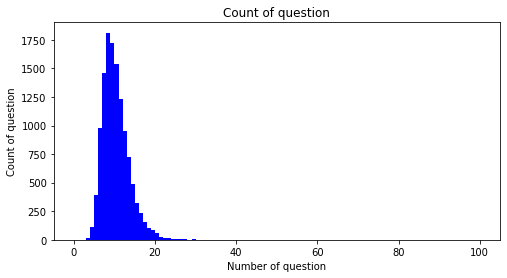

In [37]:
# Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à ÏÑ†Ïñ∏
# figsize: (Í∞ÄÎ°ú, ÏÑ∏Î°ú) ÌòïÌÉúÏùò ÌäúÌîåÎ°ú ÏûÖÎ†•
plt.figure(figsize=(8, 4))
# histogram ÏÑ†Ïñ∏
# bins: ÌûàÏä§ÌÜ†Í∑∏Îû® Í∞íÎì§Ïóê ÎåÄÌïú Î≤ÑÏºì Î≤îÏúÑ, 
# range: xÏ∂ï Í∞íÏùò Î≤îÏúÑ
# facecolor: Í∑∏ÎûòÌîÑ ÏÉâÏÉÅ
# label: Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú ÎùºÎ≤®
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
# Í∑∏ÎûòÌîÑ Ï†úÎ™©
plt.title('Count of question')
# Í∑∏ÎûòÌîÑ x Ï∂ï ÎùºÎ≤®
plt.xlabel('Number of question')
# Í∑∏ÎûòÌîÑ y Ï∂ï ÎùºÎ≤®
plt.ylabel('Count of question')
plt.show()

In [38]:
# Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥
print(f"question Í∏∏Ïù¥ ÏµúÎåÄ:    {np.max(train_question_counts):4d}")
print(f"question Í∏∏Ïù¥ ÏµúÏÜå:    {np.min(train_question_counts):4d}")
print(f"question Í∏∏Ïù¥ ÌèâÍ∑†:    {np.mean(train_question_counts):7.2f}")
print(f"question Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®: {np.std(train_question_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# Î∞±Î∂ÑÏúÑÏàò(Percentile)Îäî ÌÅ¨Í∏∞Í∞Ä ÏûàÎäî Í∞íÎì§Î°ú Ïù¥Î§ÑÏßÑ ÏûêÎ£åÎ•º ÏàúÏÑúÎåÄÎ°ú ÎÇòÏó¥ÌñàÏùÑ Îïå Î∞±Î∂ÑÏú®Î°ú ÎÇòÌÉÄÎÇ∏ ÌäπÏ†ï ÏúÑÏπòÏùò Í∞íÏùÑ Ïù¥Î•¥Îäî Ïö©Ïñ¥Ïù¥Îã§.
# ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÌÅ¨Í∏∞Í∞Ä ÏûëÏùÄ Í≤ÉÎ∂ÄÌÑ∞ ÎÇòÏó¥ÌïòÏó¨ Í∞ÄÏû• ÏûëÏùÄ Í≤ÉÏùÑ 0, Í∞ÄÏû• ÌÅ∞ Í≤ÉÏùÑ 100ÏúºÎ°ú ÌïúÎã§.
# 100Í∞úÏùò Í∞íÏùÑ Í∞ÄÏßÑ Ïñ¥Îñ§ ÏûêÎ£åÏùò 20 Î∞±Î∂ÑÏúÑÏàòÎäî Í∑∏ ÏûêÎ£åÏùò Í∞íÎì§ Ï§ë 20Î≤àÏß∏Î°ú ÏûëÏùÄ Í∞íÏùÑ ÎúªÌïúÎã§. 50 Î∞±Î∂ÑÏúÑÏàòÎäî Ï§ëÏïôÍ∞íÍ≥º Í∞ôÎã§.
percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100Î∂ÑÏúÑ:  {percentile25:7.2f}")
print(f"question 50/100Î∂ÑÏúÑ:  {percentile50:7.2f}")
print(f"question 75/100Î∂ÑÏúÑ:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100Î∂ÑÏúÑ: {percentileMAX:7.2f}")

question Í∏∏Ïù¥ ÏµúÎåÄ:      32
question Í∏∏Ïù¥ ÏµúÏÜå:       1
question Í∏∏Ïù¥ ÌèâÍ∑†:       9.86
question Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®:    3.22
question 25/100Î∂ÑÏúÑ:     8.00
question 50/100Î∂ÑÏúÑ:     9.00
question 75/100Î∂ÑÏúÑ:    12.00
question IQR:           4.00
question MAX/100Î∂ÑÏúÑ:   18.00


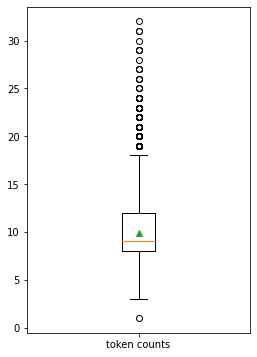

In [39]:
plt.figure(figsize=(4, 6))
# Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
# Ï≤´Î≤àÏß∏ ÌååÎùºÎ©îÌÑ∞: Ïó¨Îü¨ Î∂ÑÌè¨Ïóê ÎåÄÌïú Îç∞Ïù¥ÌÑ∞ Î¶¨Ïä§Ìä∏Î•º
# labels: ÏûÖÎ†•Ìïú Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÎùºÎ≤®
# showmeans: ÌèâÍ∑†Í∞íÏùÑ ÌëúÌòÑ
# Ï∞∏Í≥†: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

## Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (6) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Context

In [40]:
# token count
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[154, 271, 168, 190, 233, 233, 233, 233, 233, 233]

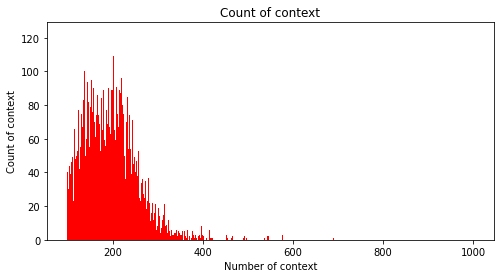

In [41]:
# Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à ÏÑ†Ïñ∏
# figsize: (Í∞ÄÎ°ú, ÏÑ∏Î°ú) ÌòïÌÉúÏùò ÌäúÌîåÎ°ú ÏûÖÎ†•
plt.figure(figsize=(8, 4))
# histogram ÏÑ†Ïñ∏
# bins: ÌûàÏä§ÌÜ†Í∑∏Îû® Í∞íÎì§Ïóê ÎåÄÌïú Î≤ÑÏºì Î≤îÏúÑ, 
# range: xÏ∂ï Í∞íÏùò Î≤îÏúÑ
# facecolor: Í∑∏ÎûòÌîÑ ÏÉâÏÉÅ
# label: Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú ÎùºÎ≤®
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
# Í∑∏ÎûòÌîÑ Ï†úÎ™©
plt.title('Count of context')
# Í∑∏ÎûòÌîÑ x Ï∂ï ÎùºÎ≤®
plt.xlabel('Number of context')
# Í∑∏ÎûòÌîÑ y Ï∂ï ÎùºÎ≤®
plt.ylabel('Count of context')
plt.show()

In [42]:
# Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥
print(f"context Í∏∏Ïù¥ ÏµúÎåÄ:    {np.max(train_context_counts):4d}")
print(f"context Í∏∏Ïù¥ ÏµúÏÜå:    {np.min(train_context_counts):4d}")
print(f"context Í∏∏Ïù¥ ÌèâÍ∑†:    {np.mean(train_context_counts):7.2f}")
print(f"context Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®: {np.std(train_context_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# Î∞±Î∂ÑÏúÑÏàò(Percentile)Îäî ÌÅ¨Í∏∞Í∞Ä ÏûàÎäî Í∞íÎì§Î°ú Ïù¥Î§ÑÏßÑ ÏûêÎ£åÎ•º ÏàúÏÑúÎåÄÎ°ú ÎÇòÏó¥ÌñàÏùÑ Îïå Î∞±Î∂ÑÏú®Î°ú ÎÇòÌÉÄÎÇ∏ ÌäπÏ†ï ÏúÑÏπòÏùò Í∞íÏùÑ Ïù¥Î•¥Îäî Ïö©Ïñ¥Ïù¥Îã§.
# ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÌÅ¨Í∏∞Í∞Ä ÏûëÏùÄ Í≤ÉÎ∂ÄÌÑ∞ ÎÇòÏó¥ÌïòÏó¨ Í∞ÄÏû• ÏûëÏùÄ Í≤ÉÏùÑ 0, Í∞ÄÏû• ÌÅ∞ Í≤ÉÏùÑ 100ÏúºÎ°ú ÌïúÎã§.
# 100Í∞úÏùò Í∞íÏùÑ Í∞ÄÏßÑ Ïñ¥Îñ§ ÏûêÎ£åÏùò 20 Î∞±Î∂ÑÏúÑÏàòÎäî Í∑∏ ÏûêÎ£åÏùò Í∞íÎì§ Ï§ë 20Î≤àÏß∏Î°ú ÏûëÏùÄ Í∞íÏùÑ ÎúªÌïúÎã§. 50 Î∞±Î∂ÑÏúÑÏàòÎäî Ï§ëÏïôÍ∞íÍ≥º Í∞ôÎã§.
percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100Î∂ÑÏúÑ:  {percentile25:7.2f}")
print(f"context 50/100Î∂ÑÏúÑ:  {percentile50:7.2f}")
print(f"context 75/100Î∂ÑÏúÑ:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100Î∂ÑÏúÑ: {percentileMAX:7.2f}")

context Í∏∏Ïù¥ ÏµúÎåÄ:     689
context Í∏∏Ïù¥ ÏµúÏÜå:      33
context Í∏∏Ïù¥ ÌèâÍ∑†:     190.88
context Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®:   60.46
context 25/100Î∂ÑÏúÑ:   146.00
context 50/100Î∂ÑÏúÑ:   187.00
context 75/100Î∂ÑÏúÑ:   227.00
context IQR:          81.00
context MAX/100Î∂ÑÏúÑ:  348.50


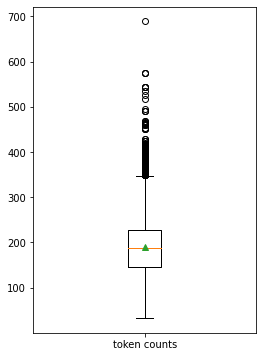

In [43]:
plt.figure(figsize=(4, 6))
# Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
# Ï≤´Î≤àÏß∏ ÌååÎùºÎ©îÌÑ∞: Ïó¨Îü¨ Î∂ÑÌè¨Ïóê ÎåÄÌïú Îç∞Ïù¥ÌÑ∞ Î¶¨Ïä§Ìä∏Î•º
# labels: ÏûÖÎ†•Ìïú Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÎùºÎ≤®
# showmeans: ÌèâÍ∑†Í∞íÏùÑ ÌëúÌòÑ
# Ï∞∏Í≥†: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

## Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (7) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Answer

In [44]:
# token count
train_answer_starts = token_starts
train_answer_starts[:10]

[78, 153, 155, 102, 28, 0, 28, 40, 86, 0]

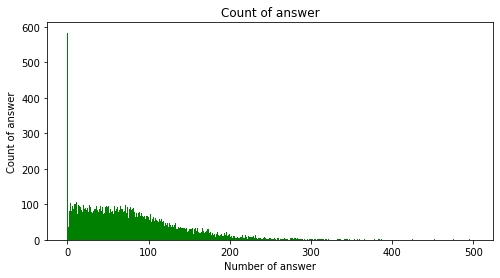

In [45]:
# Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à ÏÑ†Ïñ∏
# figsize: (Í∞ÄÎ°ú, ÏÑ∏Î°ú) ÌòïÌÉúÏùò ÌäúÌîåÎ°ú ÏûÖÎ†•
plt.figure(figsize=(8, 4))
# histogram ÏÑ†Ïñ∏
# bins: ÌûàÏä§ÌÜ†Í∑∏Îû® Í∞íÎì§Ïóê ÎåÄÌïú Î≤ÑÏºì Î≤îÏúÑ, 
# range: xÏ∂ï Í∞íÏùò Î≤îÏúÑ
# facecolor: Í∑∏ÎûòÌîÑ ÏÉâÏÉÅ
# label: Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú ÎùºÎ≤®
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
# Í∑∏ÎûòÌîÑ Ï†úÎ™©
plt.title('Count of answer')
# Í∑∏ÎûòÌîÑ x Ï∂ï ÎùºÎ≤®
plt.xlabel('Number of answer')
# Í∑∏ÎûòÌîÑ y Ï∂ï ÎùºÎ≤®
plt.ylabel('Count of answer')
plt.show()

In [46]:
# Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥
print(f"answer ÏúÑÏπò ÏµúÎåÄ:    {np.max(train_answer_starts):4d}")
print(f"answer ÏúÑÏπò ÏµúÏÜå:    {np.min(train_answer_starts):4d}")
print(f"answer ÏúÑÏπò ÌèâÍ∑†:    {np.mean(train_answer_starts):7.2f}")
print(f"answer ÏúÑÏπò ÌëúÏ§ÄÌé∏Ï∞®: {np.std(train_answer_starts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# Î∞±Î∂ÑÏúÑÏàò(Percentile)Îäî ÌÅ¨Í∏∞Í∞Ä ÏûàÎäî Í∞íÎì§Î°ú Ïù¥Î§ÑÏßÑ ÏûêÎ£åÎ•º ÏàúÏÑúÎåÄÎ°ú ÎÇòÏó¥ÌñàÏùÑ Îïå Î∞±Î∂ÑÏú®Î°ú ÎÇòÌÉÄÎÇ∏ ÌäπÏ†ï ÏúÑÏπòÏùò Í∞íÏùÑ Ïù¥Î•¥Îäî Ïö©Ïñ¥Ïù¥Îã§.
# ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÌÅ¨Í∏∞Í∞Ä ÏûëÏùÄ Í≤ÉÎ∂ÄÌÑ∞ ÎÇòÏó¥ÌïòÏó¨ Í∞ÄÏû• ÏûëÏùÄ Í≤ÉÏùÑ 0, Í∞ÄÏû• ÌÅ∞ Í≤ÉÏùÑ 100ÏúºÎ°ú ÌïúÎã§.
# 100Í∞úÏùò Í∞íÏùÑ Í∞ÄÏßÑ Ïñ¥Îñ§ ÏûêÎ£åÏùò 20 Î∞±Î∂ÑÏúÑÏàòÎäî Í∑∏ ÏûêÎ£åÏùò Í∞íÎì§ Ï§ë 20Î≤àÏß∏Î°ú ÏûëÏùÄ Í∞íÏùÑ ÎúªÌïúÎã§. 50 Î∞±Î∂ÑÏúÑÏàòÎäî Ï§ëÏïôÍ∞íÍ≥º Í∞ôÎã§.
percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100Î∂ÑÏúÑ:  {percentile25:7.2f}")
print(f"answer 50/100Î∂ÑÏúÑ:  {percentile50:7.2f}")
print(f"answer 75/100Î∂ÑÏúÑ:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100Î∂ÑÏúÑ: {percentileMAX:7.2f}")

answer ÏúÑÏπò ÏµúÎåÄ:     495
answer ÏúÑÏπò ÏµúÏÜå:       0
answer ÏúÑÏπò ÌèâÍ∑†:      77.06
answer ÏúÑÏπò ÌëúÏ§ÄÌé∏Ï∞®:   60.80
answer 25/100Î∂ÑÏúÑ:    29.00
answer 50/100Î∂ÑÏúÑ:    67.00
answer 75/100Î∂ÑÏúÑ:   110.00
answer IQR:          81.00
answer MAX/100Î∂ÑÏúÑ:  231.50


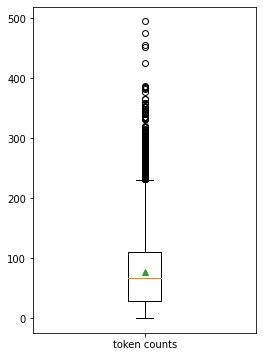

In [47]:
plt.figure(figsize=(4, 6))
# Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
# Ï≤´Î≤àÏß∏ ÌååÎùºÎ©îÌÑ∞: Ïó¨Îü¨ Î∂ÑÌè¨Ïóê ÎåÄÌïú Îç∞Ïù¥ÌÑ∞ Î¶¨Ïä§Ìä∏Î•º
# labels: ÏûÖÎ†•Ìïú Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÎùºÎ≤®
# showmeans: ÌèâÍ∑†Í∞íÏùÑ ÌëúÌòÑ
# Ï∞∏Í≥†: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

## Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (8) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Word Cloud

In [48]:
# train documents
documents = []

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú title, context, question Î¨∏Ïû•ÏùÑ Î™®Îëê Ï∂îÏ∂úÌï©ÎãàÎã§. 
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]   # Í∑∏Ï§ë Îß® Ïïû 10Í∞úÎßå ÌôïÏù∏Ìï¥ Î¥ÖÎãàÎã§.

  0%|          | 0/60000 [00:00<?, ?it/s]

['Îã§ÌÖå_Í∏∞ÎØ∏ÏΩî',
 "Ïû¨Ìå¨ Ïò§ÌîàÏóêÏÑú 4Ìöå Ïö∞ÏäπÌïòÏòÄÏúºÎ©∞, ÌÜµÏÇ∞ Îã®Ïãù 200Ïäπ Ïù¥ÏÉÅÏùÑ Í±∞ÎëêÏóàÎã§. 1994ÎÖÑ ÏÉùÏï† ÏµúÏ¥àÎ°ú ÏÑ∏Í≥Ñ Îû≠ÌÇπ 10ÏúÑÍ∂åÏóê ÏßÑÏûÖÌïòÏòÄÎã§. 1992ÎÖÑÏóêÎäî WTAÎ°úÎ∂ÄÌÑ∞ 'Ïò¨Ìï¥ Í∞ÄÏû• ÎßéÏùÄ Ìñ•ÏÉÅÏùÑ Î≥¥Ïó¨Ï§Ä ÏÑ†ÏàòÏÉÅ'(Most Improved Player Of The Year)ÏùÑ ÏàòÏó¨Î∞õÏïòÏúºÎ©∞, ÏùºÎ≥∏ ÎÇ®Ïûê Ìå®ÏÖò ÌòëÌöå(Japan Men's Fashion Association)Îäî Í∑∏ÎÖÄÎ•º 'Í∞ÄÏû• Ìå®ÏÖîÎÑàÎ∏îÌïú ÏÑ†Ïàò'(Most Fashionable)Î°ú Ïπ≠ÌñàÎã§. ÏÉùÏï† Îëê Î≤àÏß∏ Ïò¨Î¶ºÌîΩ Ï∞∏Í∞Ä ÏßÅÌõÑÏù∏ 1996ÎÖÑ 9Ïõî 24Ïùº ÏµúÏ¥àÎ°ú ÏùÄÌá¥Î•º ÏÑ†Ïñ∏ÌïòÏòÄÎã§. Ïù¥ÌõÑ 12ÎÖÑÎßåÏù∏ 2008ÎÖÑ 4ÏõîÏóê ÏòàÏÉÅÏπò Î™ªÌïú Î≥µÍ∑Ä ÏÑ†Ïñ∏ÏùÑ ÌïòÍ≥† Ìà¨Ïñ¥Ïóê ÎêòÎèåÏïÑÏôîÎã§. 2008ÎÖÑ 6Ïõî 15Ïùº ÎèÑÏøÑ ÏïÑÎ¶¨ÏïÑÏºÄ Ïù∏ÌÑ∞ÎÇ¥ÏÖîÎÑê Ïó¨Ïûê Ïò§ÌîàÏóêÏÑú Î≥µÍ∑Ä ÌõÑ Ï≤´ Ïö∞ÏäπÏùÑ Í∏∞Î°ùÌñàÏúºÎ©∞, 2009ÎÖÑ 9Ïõî 27ÏùºÏóêÎäî ÌïúÍµ≠ÏóêÏÑú Ïó¥Î¶∞ ÌïúÏÜî ÏΩîÎ¶¨ÏïÑ Ïò§Ìîà ÎåÄÌöåÏóêÏÑú Ïö∞ÏäπÌïòÎ©¥ÏÑú Î≥µÍ∑Ä ÌõÑ Ï≤´ WTA Ìà¨Ïñ¥Í∏â ÎåÄÌöå Ïö∞ÏäπÏùÑ Í∏∞Î°ùÌñàÎã§. ÌïúÏà® Ï¢Ä ÏûëÏûë Ïâ¨Ïñ¥!",
 'Îã§ÌÖå Í∏∞ÎØ∏ÏΩîÍ∞Ä ÏµúÏ¥àÎ°ú ÏùÄÌá

In [49]:
# documentsÎ•º Ï†ÑÎ∂Ä Ïù¥Ïñ¥ ÌïòÎÇòÏùò Î¨∏Ïû•ÏúºÎ°ú ÎßåÎì§Î©¥ Ïù¥Î†áÍ≤å Î≥¥ÏûÖÎãàÎã§. 
" ".join(documents[:10])

'Îã§ÌÖå_Í∏∞ÎØ∏ÏΩî Ïû¨Ìå¨ Ïò§ÌîàÏóêÏÑú 4Ìöå Ïö∞ÏäπÌïòÏòÄÏúºÎ©∞, ÌÜµÏÇ∞ Îã®Ïãù 200Ïäπ Ïù¥ÏÉÅÏùÑ Í±∞ÎëêÏóàÎã§. 1994ÎÖÑ ÏÉùÏï† ÏµúÏ¥àÎ°ú ÏÑ∏Í≥Ñ Îû≠ÌÇπ 10ÏúÑÍ∂åÏóê ÏßÑÏûÖÌïòÏòÄÎã§. 1992ÎÖÑÏóêÎäî WTAÎ°úÎ∂ÄÌÑ∞ \'Ïò¨Ìï¥ Í∞ÄÏû• ÎßéÏùÄ Ìñ•ÏÉÅÏùÑ Î≥¥Ïó¨Ï§Ä ÏÑ†ÏàòÏÉÅ\'(Most Improved Player Of The Year)ÏùÑ ÏàòÏó¨Î∞õÏïòÏúºÎ©∞, ÏùºÎ≥∏ ÎÇ®Ïûê Ìå®ÏÖò ÌòëÌöå(Japan Men\'s Fashion Association)Îäî Í∑∏ÎÖÄÎ•º \'Í∞ÄÏû• Ìå®ÏÖîÎÑàÎ∏îÌïú ÏÑ†Ïàò\'(Most Fashionable)Î°ú Ïπ≠ÌñàÎã§. ÏÉùÏï† Îëê Î≤àÏß∏ Ïò¨Î¶ºÌîΩ Ï∞∏Í∞Ä ÏßÅÌõÑÏù∏ 1996ÎÖÑ 9Ïõî 24Ïùº ÏµúÏ¥àÎ°ú ÏùÄÌá¥Î•º ÏÑ†Ïñ∏ÌïòÏòÄÎã§. Ïù¥ÌõÑ 12ÎÖÑÎßåÏù∏ 2008ÎÖÑ 4ÏõîÏóê ÏòàÏÉÅÏπò Î™ªÌïú Î≥µÍ∑Ä ÏÑ†Ïñ∏ÏùÑ ÌïòÍ≥† Ìà¨Ïñ¥Ïóê ÎêòÎèåÏïÑÏôîÎã§. 2008ÎÖÑ 6Ïõî 15Ïùº ÎèÑÏøÑ ÏïÑÎ¶¨ÏïÑÏºÄ Ïù∏ÌÑ∞ÎÇ¥ÏÖîÎÑê Ïó¨Ïûê Ïò§ÌîàÏóêÏÑú Î≥µÍ∑Ä ÌõÑ Ï≤´ Ïö∞ÏäπÏùÑ Í∏∞Î°ùÌñàÏúºÎ©∞, 2009ÎÖÑ 9Ïõî 27ÏùºÏóêÎäî ÌïúÍµ≠ÏóêÏÑú Ïó¥Î¶∞ ÌïúÏÜî ÏΩîÎ¶¨ÏïÑ Ïò§Ìîà ÎåÄÌöåÏóêÏÑú Ïö∞ÏäπÌïòÎ©¥ÏÑú Î≥µÍ∑Ä ÌõÑ Ï≤´ WTA Ìà¨Ïñ¥Í∏â ÎåÄÌöå Ïö∞ÏäπÏùÑ Í∏∞Î°ùÌñàÎã§. ÌïúÏà® Ï¢Ä ÏûëÏûë Ïâ¨Ïñ¥! Îã§ÌÖå Í∏∞ÎØ∏ÏΩîÍ∞Ä ÏµúÏ¥àÎ°ú ÏùÄÌá¥ ÏÑ

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


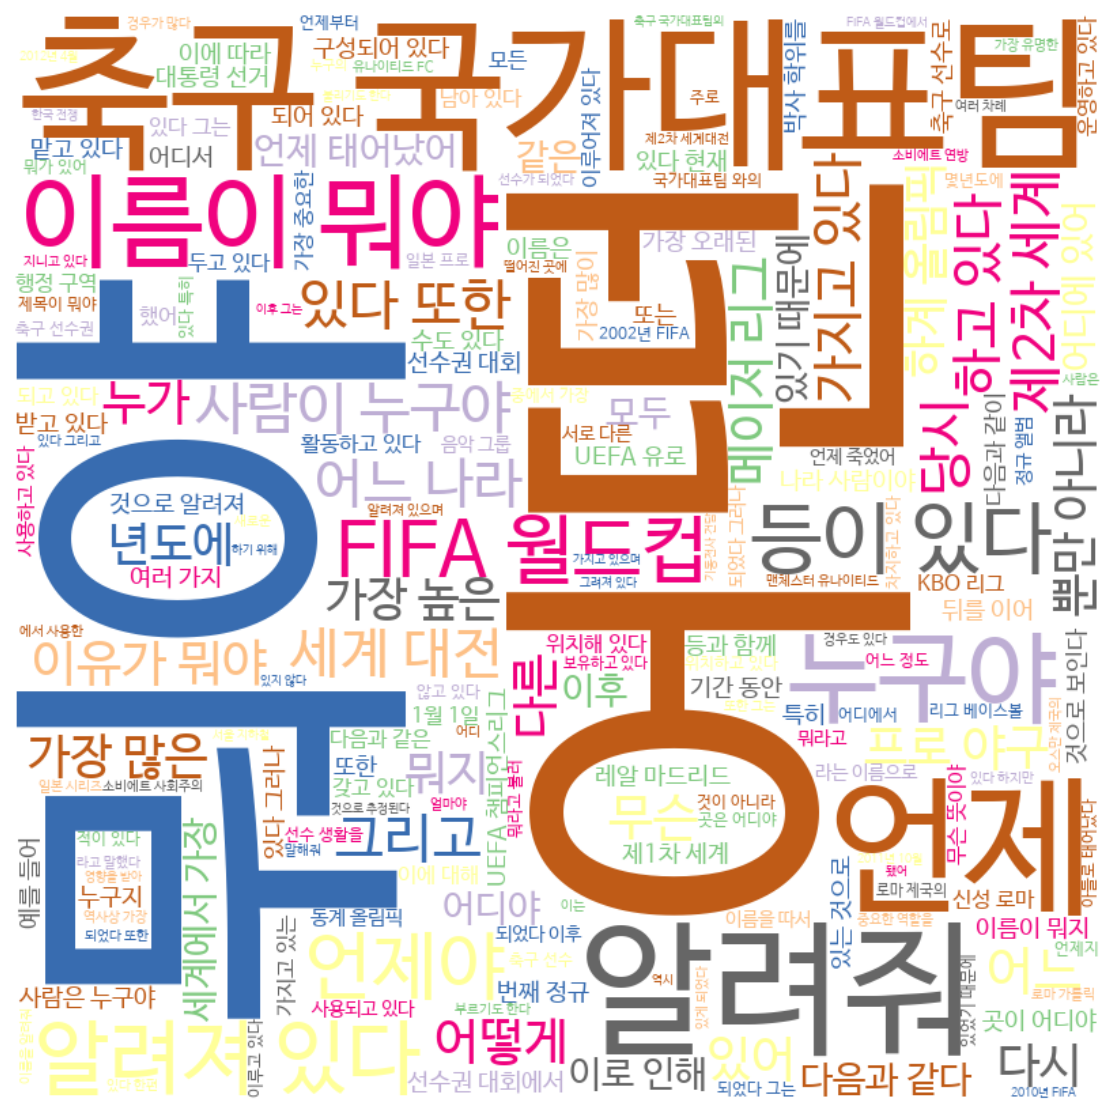

In [51]:
# WordCloudÎ°ú " ".join(documents)Î•º Ï≤òÎ¶¨Ìï¥ Î¥ÖÎãàÎã§. 
wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white',
    colormap='Accent_r',
    font_path=fontpath
    ).generate(" ".join(documents))
plt.figure(figsize=(10, 10))
# image Ï∂úÎ†•, interpolation Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôî ÏòµÏÖò
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤òÎ¶¨ (9) Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [52]:
train_json = os.path.join(data_dir + '/TRAIN_preprocessing.json')
dev_json = os.path.join(data_dir + '/TEST_preprocessing.json') 

In [53]:
class Config(dict):
    """
    jsonÏùÑ config ÌòïÌÉúÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_query_length': 64, 'max_seq_length': 384}

In [54]:
# ÏÉùÏÑ±Ìïú Îç∞Ïù¥ÌÑ∞ÏÖã ÌååÏùºÏùÑ Î©îÎ™®Î¶¨Ïóê Î°úÎî©ÌïòÎäî Ìï®Ïàò
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):

          data = json.loads(line)
          token_start = data.get("token_start")
          token_end = data.get("token_end")
          question = data["question"][:args.max_query_length]
          context = data["context"]
          answer_tokens = " ".join(context[token_start:token_end + 1])
          context_len = args.max_seq_length - len(question) - 3

          if token_end >= context_len:
              # ÏµúÎåÄ Í∏∏Ïù¥ÎÇ¥Ïóê tokenÏù¥ Îì§Ïñ¥Í∞ÄÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ Ï≤òÎ¶¨ÌïòÏßÄ ÏïäÏùå
              n_discard += 1
              continue
          context = context[:context_len]
          assert len(question) + len(context) <= args.max_seq_length - 3

          tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
          ids = [vocab.piece_to_id(token) for token in tokens]
          ids += [0] * (args.max_seq_length - len(ids))
          inputs.append(ids)
          segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
          segs += [0] * (args.max_seq_length - len(segs))
          segments.append(segs)
          token_start += (len(question) + 2)
          labels_start.append(token_start)
          token_end += (len(question) + 2)
          labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [70]:
with tf.device('device:GPU:0'):
# train data load
  train_inputs, train_labels = load_data(args, train_json)
  print(f"train_inputs: {train_inputs[0].shape}")
  print(f"train_inputs: {train_inputs[1].shape}")
  print(f"train_labels: {train_labels[0].shape}")
  print(f"train_labels: {train_labels[1].shape}")

  # dev data load
  dev_inputs, dev_labels = load_data(args, dev_json)
  print(f"dev_inputs: {dev_inputs[0].shape}")
  print(f"dev_inputs: {dev_inputs[1].shape}")
  print(f"dev_labels: {dev_labels[0].shape}")
  print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 64
train_inputs: (87716, 384)
train_inputs: (87716, 384)
train_labels: (87716,)
train_labels: (87716,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 12
dev_inputs: (12440, 384)
dev_inputs: (12440, 384)
dev_labels: (12440,)
dev_labels: (12440,)


((array([[    5, 13787, 24839, ...,     0,     0,     0],
         [    5,    11,  8904, ...,     0,     0,     0],
         [    5, 12323, 28608, ...,     0,     0,     0],
         ...,
         [    5, 24572,  2007, ...,     0,     0,     0],
         [    5,    11, 27860, ...,     0,     0,     0],
         [    5,   383,    13, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([116,  27, 102, ...,  28,  45, 165]),
  array([121,  31, 110, ...,  36,  50, 166])))

In [56]:
# QuestionÍ≥º ContextÍ∞Ä Ìè¨Ìï®Îêú ÏûÖÎ†•Îç∞Ïù¥ÌÑ∞ 1Î≤àÏß∏
train_inputs[0][0]

array([    5, 13787, 24839, 10305,  1053,  2323, 18778,    58,   139,
        9675,    47,     4, 18404,  2804,    22,    46,   168,   908,
         450,     8,  4256, 11030,  1570,   470,  6298,  4280,     7,
        1218,    15,  6315,  1053,   238,  7410,    66, 14432,    13,
        3444,    54,     7,  1238,   308,   777,  5884,   420,    62,
        2194,    60,   141,   189, 18762, 16941,   611,   121,  3112,
         579,  8970,    11, 27598,  1772,  2613,  1181,   599, 27915,
       15461,  2007, 27103,    12,    16,  4652, 16634,     8,   146,
        1020,  5060,  2633,    14, 17052, 21492,   476,  1173,    56,
         162,   540, 13273,  3032, 20074,    12,    10,  6602,    62,
          19,   148,  1168,  2681,   827,  1761,    33,   611,  3112,
         579,  8970,   540, 13273,  3032, 12684,    12,    21,  2905,
          53,     7,  6315,    98,   407,   569,  2107, 22606,  1153,
          15,    81,    23,   544,    28,  1053,  2323,    20, 11152,
           7,    83,

In [57]:
# QuestionÏùÑ 0ÏúºÎ°ú, ContextÎ•º 1Î°ú Íµ¨Î∂ÑÌï¥ Ï§Ä Segment Îç∞Ïù¥ÌÑ∞ 1Î≤àÏß∏
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [58]:
# AnswerÏúÑÏπòÏùò ÏãúÏûëÏ†êÍ≥º ÎÅùÏ†ê ÎùºÎ≤® 1Î≤àÏß∏
train_labels[0][0], train_labels[1][0]

(116, 121)

##LSTMÏùÑ Ïù¥Ïö©Ìï¥Î≥¥Ïûê.¬∂

Ïö∞ÏÑ† KorQuAD ÌÉúÏä§ÌÅ¨Î•º LSTM Î™®Îç∏ÏùÑ ÌôúÏö©ÌïòÏó¨ ÌïôÏäµÌï¥ Î≥¥Ïûê.
Îã§ÏÜå Î≥µÏû°Ìï¥ Î≥¥Ïù¥Í≤†ÏßÄÎßå InputÏù¥ 2Í∞ú, OutputÏù¥ 2Í∞úÏù∏ Î™®Îç∏Ïù¥ÎùºÎäî Ï†êÏóê Ï£ºÎ™©ÌïòÏûê.
2Í∞úÏùò InputÏùÄ Ïù¥Ï†Ñ Ïä§ÌÖùÏóêÏÑú Î≥¥ÏïòÎçò train_inputs[0], train_inputs[1] Ïù¥ Îì§Ïñ¥Í∞ÑÎã§.
Í∞ÅÍ∞Å Question+Context Ïùò Îç∞Ïù¥ÌÑ∞ÏôÄ Segment Ïù¥Îã§.
Í∑∏Î¶¨Í≥† OutputÏùÄ AnswerÏùò ÏãúÏûëÏ†êÍ≥º ÎÅùÏ†êÏùò ÏúÑÏπòÏûÖÎãàÎã§.

In [ ]:
def build_model_lstm(n_vocab, n_seq, d_model):
    tokens = tf.keras.layers.Input((None,), name='tokens')
    segments = tf.keras.layers.Input((None,), name='segments')

    hidden = tf.keras.layers.Embedding(n_vocab, d_model)(tokens) + tf.keras.layers.Embedding(2, d_model)(segments) # (bs, n_seq, d_model)

    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.Dense(2)(hidden) # (bs, n_seq, 2)
    start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)
    start_logits = tf.squeeze(start_logits, axis=-1)  # (bs, n_seq)
    start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)
    end_logits = tf.squeeze(end_logits, axis=-1)  # (bs, n_seq)
    end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

    model = tf.keras.Model(inputs=(tokens, segments), outputs=(start_outputs, end_outputs))
    return model

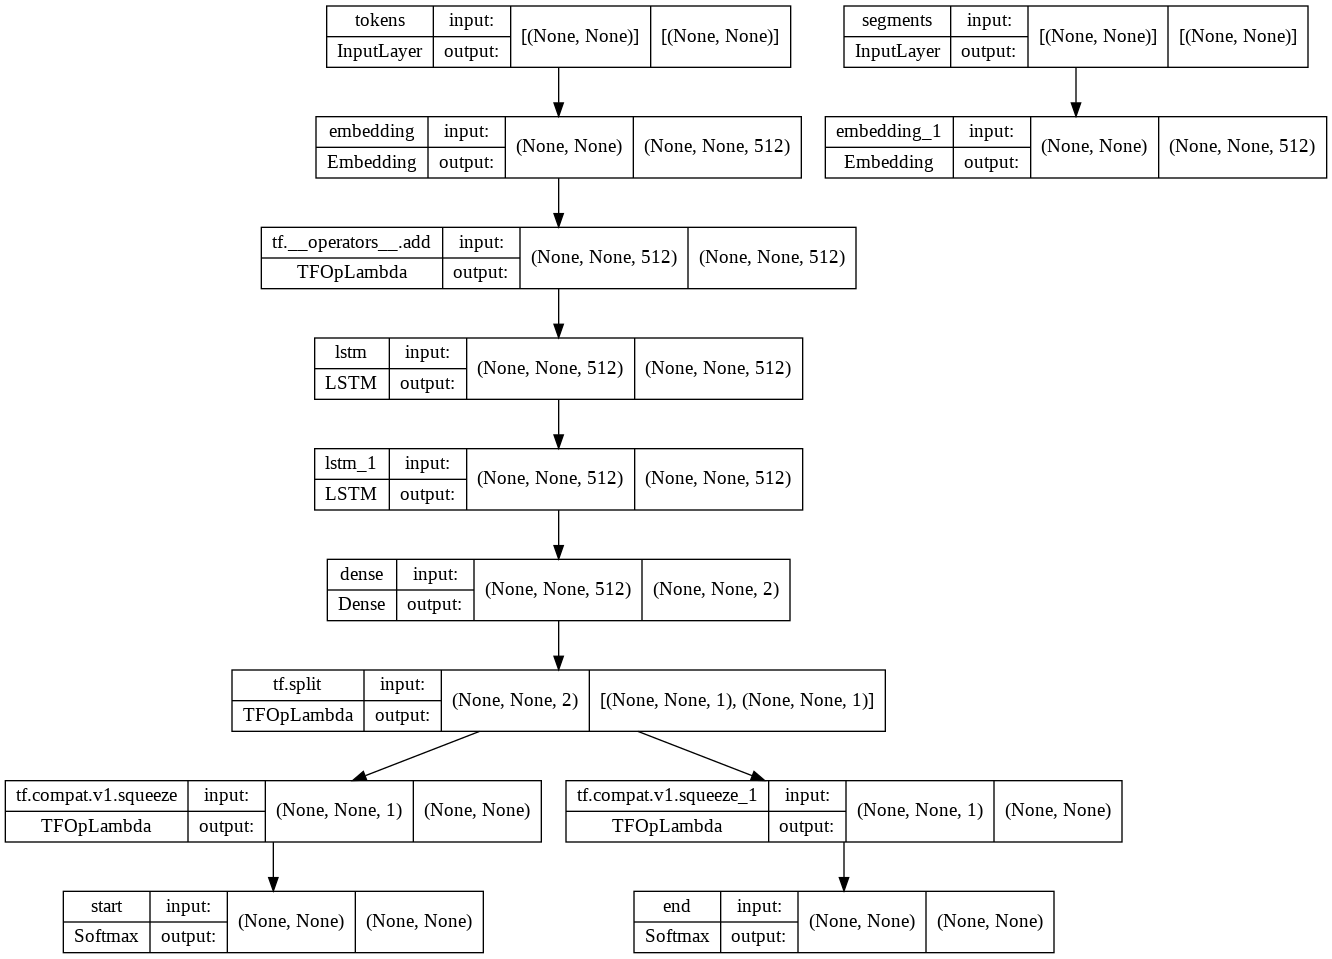

In [ ]:
model = build_model_lstm(n_vocab=len(vocab), n_seq=512, d_model=512)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_start_accuracy', patience=3)
# save weights
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(data_dir, "korquad_lstm.hdf5"), monitor='val_start_accuracy', verbose=1, save_best_only=True, mode='max', save_freq='epoch', save_weights_only=True)

history = model.fit(train_inputs, train_labels, epochs=10, batch_size=128, validation_data=(dev_inputs, dev_labels), callbacks=[early_stopping, save_weights])

Epoch 1/10
181/686 [======>.......................] - ETA: 4:26:43 - loss: 9.5016 - start_loss: 4.6225 - end_loss: 4.8791 - start_accuracy: 0.0549 - end_accuracy: 0.0500

KeyboardInterrupt: ignored

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


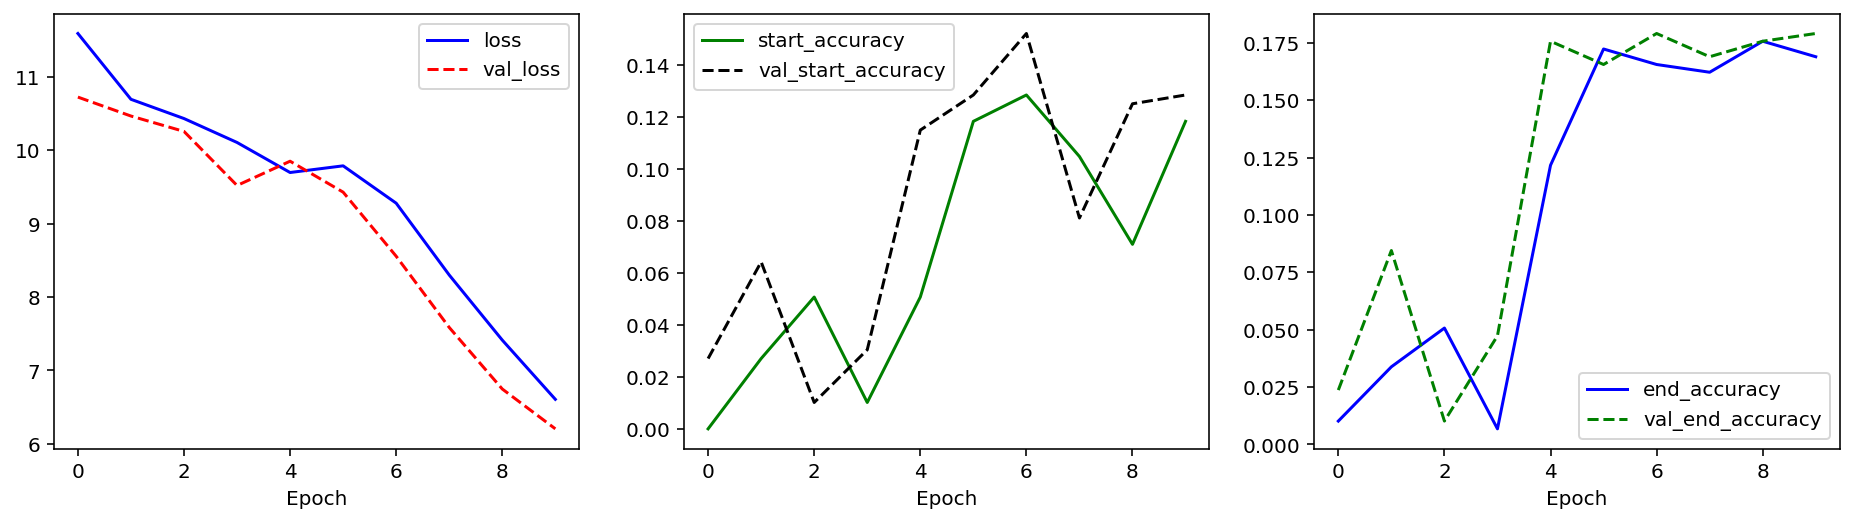

In [ ]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['start_accuracy'], 'g-', label='start_accuracy')
plt.plot(history.history['val_start_accuracy'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['end_accuracy'], 'b-', label='end_accuracy')
plt.plot(history.history['val_end_accuracy'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## BERT

In [59]:
# Ïú†Ìã∏Î¶¨Ìã∞ Ìï®ÏàòÎì§

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation Ìï®Ïàò
    :param x: ÏûÖÎ†• Í∞í
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer ÏÉùÏÑ±
    :param stddev: ÏÉùÏÑ±Ìï† ÎûúÎç§ Î≥ÄÏàòÏùò ÌëúÏ§ÄÌé∏Ï∞®
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer ÏÉùÏÑ±
    """
    return tf.zeros_initializer


class Config(dict):
    """
    jsonÏùÑ config ÌòïÌÉúÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        fileÏóêÏÑú ConfigÎ•º ÏÉùÏÑ± Ìï®
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [60]:
# mode == "embedding" Ïùº Í≤ΩÏö∞ Token Embedding Layer Î°ú ÏÇ¨Ïö©ÎêòÎäî layer ÌÅ¥ÎûòÏä§ÏûÖÎãàÎã§. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight ÏÉùÏÑ±
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :param mode: Ïã§Ìñâ Î™®Îìú
        :return: embedding or linear Ïã§Ìñâ Í≤∞Í≥º
        """
        # modeÍ∞Ä embeddingÏùº Í≤ΩÏö∞ embedding lookup Ïã§Ìñâ
        if mode == "embedding":
            return self._embedding(inputs)
        # modeÍ∞Ä linearÏùº Í≤ΩÏö∞ linear Ïã§Ìñâ
        elif mode == "linear":
            return self._linear(inputs)
        # modeÍ∞Ä Í∏∞ÌÉÄÏùº Í≤ΩÏö∞ Ïò§Î•ò Î∞úÏÉù
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: ÏûÖÎ†•
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [61]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :return embed: positional embedding lookup Í≤∞Í≥º
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [62]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [63]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [64]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: inputs
        :return ff_val: feed forward Ïã§Ìñâ Í≤∞Í≥º
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [65]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer Ïã§Ìñâ
        :param enc_embed: enc_embed ÎòêÎäî Ïù¥Ï†Ñ EncoderLayerÏùò Ï∂úÎ†•
        :param self_mask: enc_tokensÏùò pad mask
        :return enc_out: EncoderLayer Ïã§Ìñâ Í≤∞Í≥º
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [66]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer Ïã§Ìñâ
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS Í≤∞Í≥º logits
        :return logits_lm: LM Í≤∞Í≥º logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: ÏûÖÎ†• tokens
        :param segments: ÏûÖÎ†• segments
        :return embed: embedding Í≤∞Í≥º
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [67]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer Ïã§Ìñâ
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS Í≤∞Í≥º logits
        :return logits_lm: LM Í≤∞Í≥º logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: ÏûÖÎ†• tokens
        :param segments: ÏûÖÎ†• segments
        :return embed: embedding Í≤∞Í≥º
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

### BERT Î™®Îç∏ÏùÑ Ïù¥Ïö©Ìïú ÎèÑÏ†Ñ¬∂

BERT Î™®Îç∏ÏùÑ ÌôúÏö©ÌïòÏó¨, LSTMÏúºÎ°ú ÌíÄÏñ¥Î≥¥ÏïòÎçò KorQuAD ÌÉúÏä§ÌÅ¨Î•º Îã§Ïãú ÌïôÏäµÌï¥ Î≥¥Ïûê.
Î™®Îç∏Ïùò Ï∞®Ïù¥Îßå ÎπÑÍµêÌï¥ Î≥¥Í∏∞ ÏúÑÌï¥ ÏùºÎ∂ÄÎü¨ Îëê Î™®Îç∏Ïù¥ ÏÇ¨Ïö©ÌïòÎäî TokenizerÎ•º ÎèôÏùºÌïòÍ≤å Íµ¨ÏÑ±ÌïòÎã§.
ÏïÑÎûòÎäî BERT Î†àÏù¥Ïñ¥Ïóê Fully Connected layerÎ•º Î∂ôÏñ¥ KorQuADÏö©ÏúºÎ°ú finetuneÌïòÍ∏∞ ÏúÑÌïú Î™®Îç∏ ÌÅ¥ÎûòÏä§Ïù¥Îã§.

In [68]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [69]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 384,
 'n_vocab': 32007}

https://meissa.tistory.com/m/69

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 607334874857777090
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6098914335287881380
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [71]:
bert_batch_size = 32

with tf.device('/device:GPU:0'):
  train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
  dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [ ]:
model = BERT4KorQuAD(config)

In [72]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()


In [73]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()


In [74]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(1): ########
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

NameError: ignored

## 5. Pretrained modelÏùò ÌôúÏö©¬∂

pretrained modelÏùÑ ÌôúÏö©Ìï¥ Î≥¥Ïûê.
ÏÇ¨Ïö©Ìï¥Ïïº Ìï† Î™®Îç∏ Íµ¨Ï°∞ÎÇò Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨Ï°∞, Î∞∞Ïπò Íµ¨Ï°∞Îäî Ïù¥Ï†Ñ Ïä§ÌÖùÍ≥º ÎèôÏùºÌïòÎã§.
Ïù¥ÎØ∏ Îã§Ïö¥Î°úÎìúÌïú pretrained modelÏùÑ ÌôúÏö©ÌïòÎäî ÌïôÏäµÏùÑ Îã§Ïãú ÏßÑÌñâÌï¥ Î≥¥Ïûê.

## STEP 1. pretrained model Î°úÎî©ÌïòÍ∏∞

In [75]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

with tf.device('device:GPU:0'):
  model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model ÏùÑ Î°úÎìúÌïòÍ∏∞ ÏúÑÌï¥ Î®ºÏ†Ä Î™®Îç∏Ïù¥ ÏÉùÏÑ±ÎêòÏñ¥ ÏûàÏñ¥Ïïº ÌïúÎã§.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint ÌååÏùºÎ°úÎ∂ÄÌÑ∞ ÌïÑÏöîÌïú layerÎ•º Î∂àÎü¨Ïò®Îã§. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  10662400  
                                                                 
 dense_18 (Dense)            multiple                  514       
                                                                 
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


## STEP 2. pretrained model finetune ÌïòÍ∏∞

In [79]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4) # learning rate 5e-4(0.0005) ----> 3e-4(0.0003) ÎÇÆÏ∂§, ÏïÑÎã¥ ÏòµÌã∞ÎßàÏù¥Ï†ÄÎäî Í∑∏ÎåÄÎ°ú

best_acc = .0
patience = 0

# trainingÍ∞í, validationÏùò Í∞ÅÍ∞Å accuracy, lossÍ∞í tracing

history = {'train_start_loss': [], 
           'train_end_loss': [], 
           'train_start_acc': [], 
           'train_end_acc': [],
           'val_start_loss': [], 
           'val_end_loss': [],
           'val_start_acc': [], 
           'val_end_acc': []}

for epoch in range(5): # Ï¥ù 20ÏóêÌè≠
    # train set ÌïôÏäµ
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, train_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # ÌïôÏäµÍ≥ºÏ†ï ÏãúÍ∞ÅÌôî
    history['train_start_loss'].append(start_loss)
    history['train_end_loss'].append(end_loss)
    history['train_start_acc'].append(start_acc)
    history['train_end_acc'].append(end_acc)
    
    # validation set ÌïôÏäµ
    train_epoch(model, dev_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # ÌïôÏäµÍ≥ºÏ†ï ÏãúÍ∞ÅÌôî
    history['val_start_loss'].append(start_loss)
    history['val_end_loss'].append(end_loss)
    history['val_start_acc'].append(start_acc)
    history['val_end_acc'].append(end_acc)

    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/2742 [00:00<?, ?it/s]

eval 0 >> loss: 0.1919, 0.2138, acc: 0.9460, 0.9385


  0%|          | 0/389 [00:00<?, ?it/s]

eval 0 >> loss: 0.3978, 0.3929, acc: 0.8935, 0.8911
save best model


  0%|          | 0/2742 [00:00<?, ?it/s]

eval 1 >> loss: 0.2001, 0.2196, acc: 0.9431, 0.9376


  0%|          | 0/389 [00:00<?, ?it/s]

eval 1 >> loss: 0.3552, 0.3925, acc: 0.9033, 0.8996
save best model


  0%|          | 0/2742 [00:00<?, ?it/s]

eval 2 >> loss: 0.1972, 0.2039, acc: 0.9439, 0.9411


  0%|          | 0/389 [00:00<?, ?it/s]

eval 2 >> loss: 0.3320, 0.3920, acc: 0.9141, 0.8976
save best model


  0%|          | 0/2742 [00:00<?, ?it/s]

eval 3 >> loss: 0.1861, 0.2016, acc: 0.9464, 0.9434


  0%|          | 0/389 [00:00<?, ?it/s]

eval 3 >> loss: 0.2648, 0.3193, acc: 0.9272, 0.9124
save best model


  0%|          | 0/2742 [00:00<?, ?it/s]

eval 4 >> loss: 0.1462, 0.1552, acc: 0.9580, 0.9558


  0%|          | 0/389 [00:00<?, ?it/s]

eval 4 >> loss: 0.2545, 0.2831, acc: 0.9300, 0.9246
save best model


## STEP 3. Inference ÏàòÌñâÌïòÍ∏∞
finetune ÌïôÏäµÏù¥ ÏôÑÎ£åÎêú modelÏùÑ ÌôúÏö©ÌïòÏó¨ Ïã§Ï†ú ÌÄ¥Ï¶à ÌíÄÏù¥ Í≤∞Í≥ºÎ•º ÌôïÏù∏Ìï¥ Î≥¥Ïûê

### üî•

In [83]:
def do_predict(model, question, context):
    """
    ÏûÖÎ†•Ïóê ÎåÄÌïú ÎãµÎ≥Ä ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò
    :param model: model
    :param question: ÏûÖÎ†• Î¨∏ÏûêÏó¥
    :param context: ÏûÖÎ†• Î¨∏ÏûêÏó¥
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

dev_json = os.path.join('/content/drive/MyDrive/data/TEST_preprocessing.json')

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("ÏßàÎ¨∏ : ", question)
            print("ÏßÄÎ¨∏ : ", context)
            print("Ï†ïÎãµ : ", answer)
            print("ÏòàÏ∏° : ", answer_predict, "\n")
        if 100 < i:
            break

0
ÏßàÎ¨∏ :  Ìå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§Îäî Ïñ¥ÎîîÏóêÏÑú Î∞©ÏÜ°ÌñàÏñ¥
ÏßÄÎ¨∏ :  2010ÎÖÑ 2Ïõî 14Ïùº Ìå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§Í∞Ä Ï¢ÖÏòÅÎêòÍ≥†, Ìå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§ 2Í∞Ä 2Ïõî 21Ïùº Î∞©ÏòÅÎêòÏóàÎã§. „ÄäÌå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§„ÄãÎäî 2008ÎÖÑ 3ÏõîÎ∂ÄÌÑ∞ Ï†úÏûëÏùÑ ÏãúÏûëÌïòÏòÄÏúºÎ©∞, 2008ÎÖÑ 6Ïõî 15Ïùº Ï≤´Î∞©ÏÜ° ÎêòÏóàÎã§. Ï§ÄÎßêÎ°ú ‚ÄòÌå®Îñ¥‚ÄôÏúºÎ°ú Î∂àÎ¶¨Í∏∞ÎèÑ ÌïúÎã§. 2008ÎÖÑ 8Ïõî 31Ïùº, Ï≤òÏùåÏúºÎ°ú ÏãúÏ≤≠Î•† 20%Î•º ÎèåÌååÌïòÏòÄÏúºÎ©∞ Ïù¥ÌõÑ SBSÏùò ÎåÄÌëú ÏòàÎä• ÌîÑÎ°úÍ∑∏Îû®ÏúºÎ°ú ÏûêÎ¶¨Ïû°ÏïòÎã§. ÏãúÍ≥®Ïóê Ï∞æÏïÑÍ∞Ä Ìï†ÏïÑÎ≤ÑÏßÄ¬∑Ìï†Î®∏ÎãàÎ•º Ïó¨Ìñâ Î≥¥ÎÇ¥ÎìúÎ¶¨Í≥† ÏßëÏùÑ Î¥êÎìúÎ¶¨Î©¥ÏÑú Î≤åÏñ¥ÏßÄÎäî ÏóêÌîºÏÜåÎìúÎ•º Îã¥ÎäîÎã§. Ìï†ÏïÑÎ≤ÑÏßÄ¬∑Ìï†Î®∏ÎãàÍªòÏÑú Î∂ÄÌÉÅÌïòÏã† ÏùºÏùÑ ÌïòÎ©¥ÏÑú Í≤åÏûÑÏùÑ ÌïòÍ≥†, ÏãùÏÇ¨Î•º Í∞ôÏù¥ ÌïòÎ©¥ÏÑú Î≤åÏñ¥ÏßÄÎäî 1Î∞ï 2ÏùºÏùò Î™®ÏäµÏùÑ Î≥¥Ïó¨Ï£ºÎäî ÌîÑÎ°úÍ∑∏Îû®Ïù¥Îã§. „ÄäÌå®Î∞ÄÎ¶¨Í∞Ä Îñ¥Îã§„ÄãÏùò Í≥†Ï†ï Ï∂úÏó∞ÏßÑÏùÄ Ïù¥Ï≤úÌù¨Î•º Ìè¨Ìï®ÌïòÏó¨ Ï¥ù 7Î™ÖÏù¥Îã§.
Ï†ïÎãµ :  SBS
ÏòàÏ∏° :  SBS 

1
ÏßàÎ¨∏ :  ÎÖ∏ÎÑ§ÏûÑÏùò Ï¢ÖÎ•òÎäî Î™á Í∞ÄÏßÄÏïº
ÏßÄÎ¨∏ :  1978ÎÖÑ Ï∫êÎÇòÎã§ ÏµúÎåÄ Ïú†ÌÜµÏ

## STEP 4. ÌïôÏäµ Í≤ΩÍ≥º ÏãúÍ∞ÅÌôî ÎπÑÍµê Î∂ÑÏÑù

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


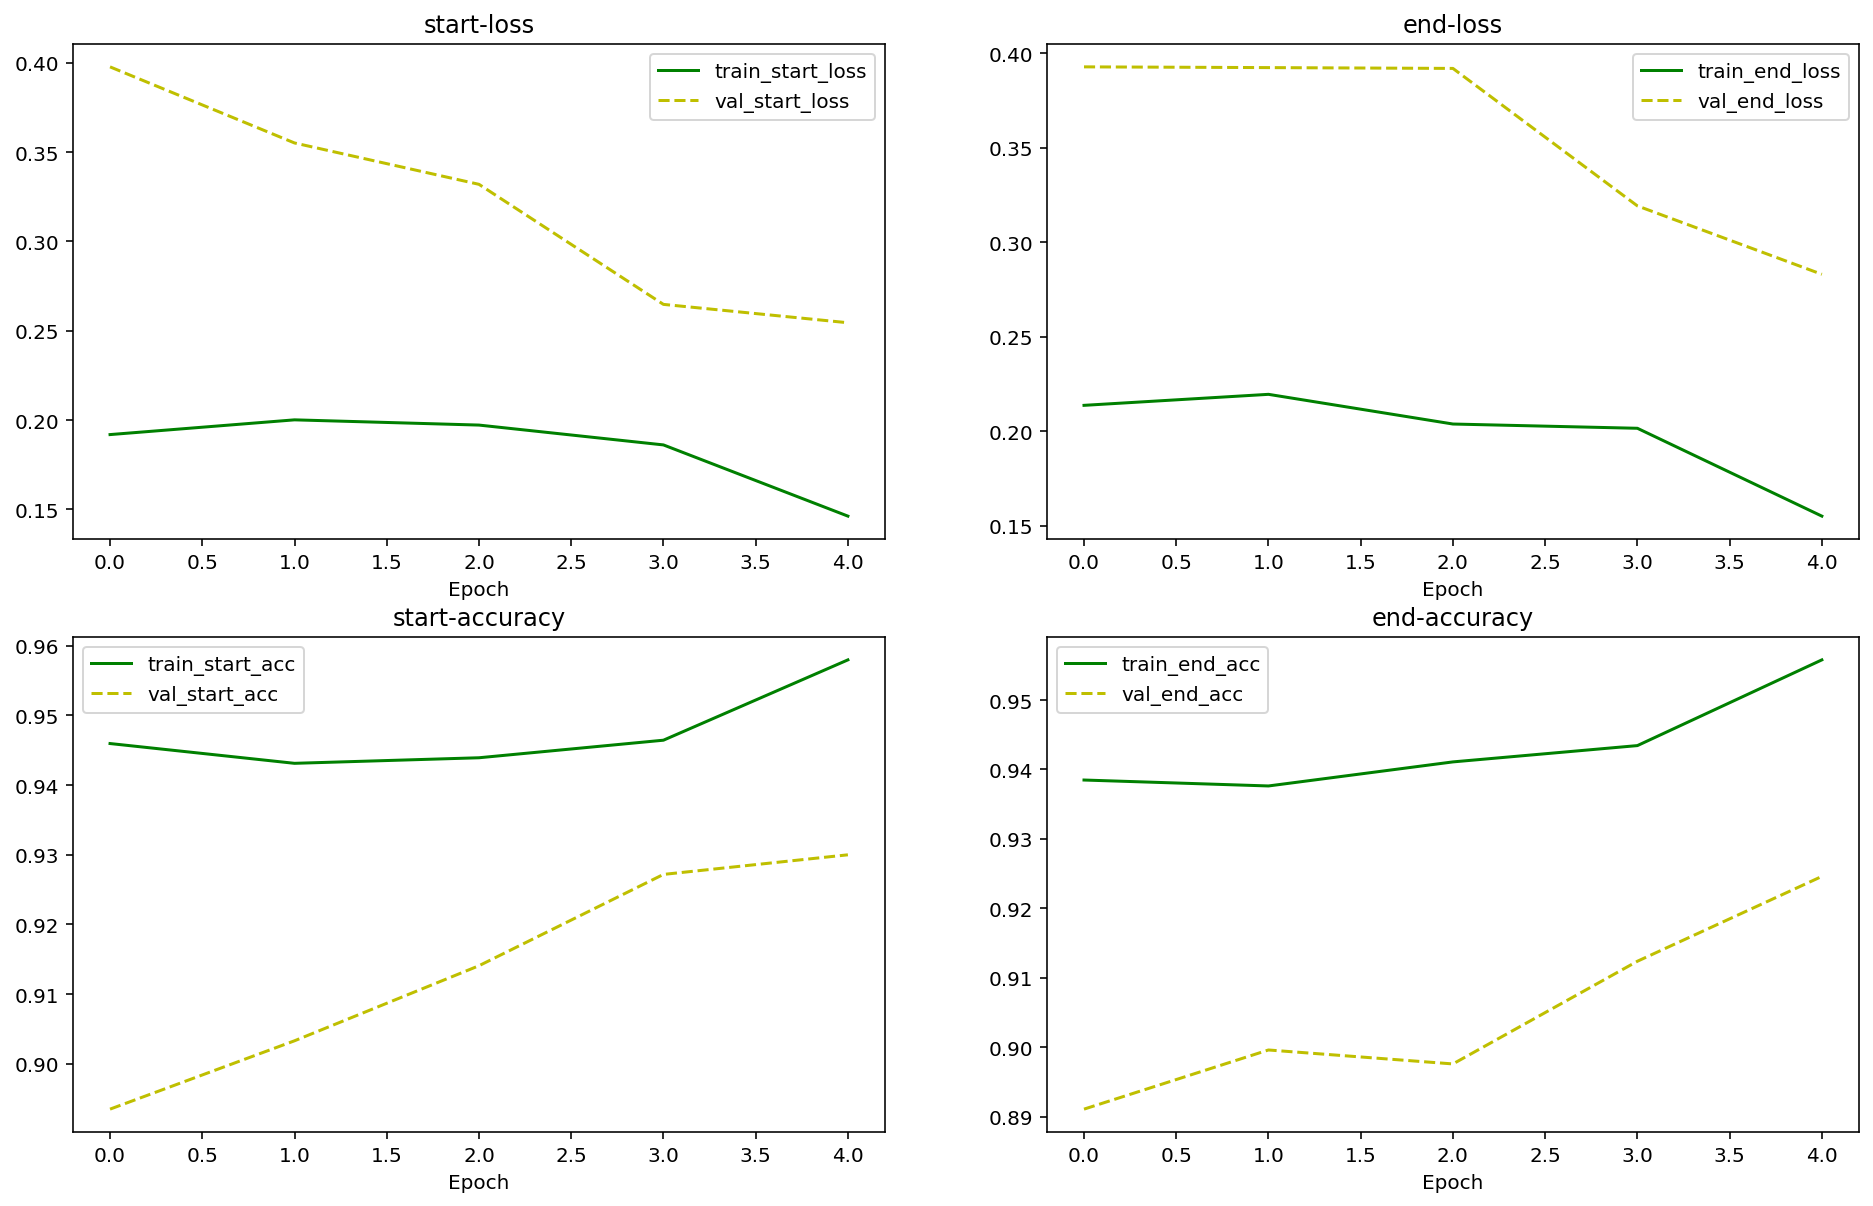

In [84]:
# ÌõàÎ†®Ïù¥ ÎßàÎ¨¥Î¶¨ÎêòÏóàÏúºÎ©¥ ÏãúÍ∞ÅÌôîÎ•º ÏßÑÌñâ.

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(history['train_start_loss'], 'g-', label='train_start_loss')
plt.plot(history['val_start_loss'], 'y--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('start-loss')

plt.subplot(2, 2, 2)
plt.plot(history['train_end_loss'], 'g-', label='train_end_loss')
plt.plot(history['val_end_loss'], 'y--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('end-loss')

plt.subplot(2, 2, 3)
plt.plot(history['train_start_acc'], 'g-', label='train_start_acc')
plt.plot(history['val_start_acc'], 'y--', label='val_start_acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('start-accuracy')


plt.subplot(2, 2, 4)
plt.plot(history['train_end_acc'], 'g-', label='train_end_acc')
plt.plot(history['val_end_acc'], 'y--', label='val_end_acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('end-accuracy')

plt.show()